<a href="https://colab.research.google.com/github/pmartin1915/ecg-classification-system/blob/main/Copy_of_ECGon715.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install neurokit2

In [ ]:
# =========================================================================
# ECG CLASSIFICATION PROJECT - PHASE 1: FOUNDATION BUILDING
# =========================================================================
# Author: DNP Student
# Purpose: Clean, organized foundation for ECG classification system
# Dataset: PTB-XL (100Hz, 12-lead) + ECG-Arrhythmia dataset
# Target: 5 conditions - NORM, MI, STTC, CD, HYP
# =========================================================================

import ast
import os
from collections import Counter
import warnings
from joblib import Parallel, delayed
import pickle
import time
from tqdm import tqdm
import gc
from google.colab import drive

warnings.filterwarnings('ignore')

# =========================================================================
# SECTION 1: ENVIRONMENT SETUP
# =========================================================================

def setup_environment():
    """Setup Google Drive connection and install required packages"""
    print("=== ENVIRONMENT SETUP ===")

    # Mount Google Drive
    print("Mounting Google Drive...")
    drive.mount('/content/drive')

    # Install required packages
    print("Installing required packages...")
    !pip install optuna pandas==2.2.2 wfdb scipy scikit-learn joblib --quiet

    # Import libraries that were just installed or might need specific versions
    import pandas as pd
    import numpy as np
    import wfdb
    # import scipy # Already installed with colab
    # import sklearn # Already installed with colab
    # import joblib # Already installed with colab


    # Create directory structure in Google Drive
    drive_path = '/content/drive/MyDrive/ECG_Classification'
    os.makedirs(f'{drive_path}/ptbxl', exist_ok=True)
    os.makedirs(f'{drive_path}/ecg-arrhythmia-dataset', exist_ok=True)
    os.makedirs(f'{drive_path}/cache', exist_ok=True)
    os.makedirs(f'{drive_path}/models', exist_ok=True)
    os.makedirs(f'{drive_path}/results', exist_ok=True)

    print(f"Created directory structure at: {drive_path}")
    # Return the imported modules and drive_path
    return pd, np, wfdb, drive_path

# Call setup_environment at the beginning to install dependencies
pd, np, wfdb, drive_path = setup_environment()


# =========================================================================
# SECTION 2: DATA DOWNLOAD MANAGEMENT
# =========================================================================

def download_ptbxl_metadata(drive_path):
    """Download PTB-XL metadata files to Google Drive"""
    print("=== DOWNLOADING PTB-XL METADATA ===")

    ptbxl_path = f'{drive_path}/ptbxl'

    # Check if files already exist
    db_file = f'{ptbxl_path}/ptbxl_database.csv'
    scp_file = f'{ptbxl_path}/scp_statements.csv'

    if os.path.exists(db_file) and os.path.exists(scp_file):
        print("✅ PTB-XL metadata files already exist in Google Drive")
        return ptbxl_path

    # Download metadata files
    print("Downloading ptbxl_database.csv...")
    !wget -q -O "{db_file}" https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv

    print("Downloading scp_statements.csv...")
    !wget -q -O "{scp_file}" https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv

    print("✅ PTB-XL metadata downloaded to Google Drive")
    return ptbxl_path

def download_arrhythmia_dataset(drive_path):
    """Download ECG-Arrhythmia dataset to Google Drive"""
    print("=== DOWNLOADING ECG-ARRHYTHMIA DATASET ===")

    arrhythmia_path = f'{drive_path}/ecg-arrhythmia-dataset'

    # Check if dataset already exists
    if os.path.exists(f'{arrhythmia_path}/1.0.0'):
        print("✅ ECG-Arrhythmia dataset already exists in Google Drive")
        return arrhythmia_path

    print("Downloading ECG-Arrhythmia dataset... (this may take a while)")
    !wget -r -q -N -c -np -P "{arrhythmia_path}" https://physionet.org/files/ecg-arrhythmia/1.0.0/

    print("✅ ECG-Arrhythmia dataset downloaded to Google Drive")
    return arrhythmia_path

# =========================================================================
# SECTION 3: METADATA PROCESSING
# =========================================================================

def load_and_process_metadata(ptbxl_path):
    """Load and process PTB-XL metadata"""
    print("=== PROCESSING METADATA ===")

    # Load main database
    print("Loading ptbxl_database.csv...")
    Y = pd.read_csv(f'{ptbxl_path}/ptbxl_database.csv', index_col='ecg_id')
    Y.scp_codes = Y.scp_codes.apply(ast.literal_eval)

    # Load diagnostic mapping
    print("Loading scp_statements.csv...")
    agg_df = pd.read_csv(f'{ptbxl_path}/scp_statements.csv', index_col=0)
    agg_df = agg_df[agg_df.diagnostic == 1]

    # Define diagnostic aggregation function
    def aggregate_diagnostic(y_dic):
        """Convert SCP codes to diagnostic superclasses"""
        return list(set(
            agg_df.loc[key].diagnostic_class for key in y_dic.keys()
            if key in agg_df.index
        ))

    # Apply diagnostic aggregation
    Y['diagnostic_superclass'] = Y.scp_codes.apply(aggregate_diagnostic)

    print(f"✅ Loaded metadata for {len(Y)} records")
    print(f"Available diagnostic classes: {sorted(agg_df.diagnostic_class.unique())}")

    return Y, agg_df

def analyze_dataset_distribution(Y):
    """Analyze and display dataset distribution"""
    print("=== DATASET DISTRIBUTION ANALYSIS ===")

    # Define target conditions
    TARGET_CONDITIONS = ['NORM', 'MI', 'STTC', 'CD', 'HYP']

    # Count all conditions
    all_conditions = []
    for diagnostic_list in Y['diagnostic_superclass']:
        all_conditions.extend(diagnostic_list)

    condition_counts = Counter(all_conditions)

    print(f"Target conditions: {TARGET_CONDITIONS}")
    print("\nCondition distribution:")
    for condition in TARGET_CONDITIONS:
        count = condition_counts.get(condition, 0)
        print(f"  {condition}: {count:,} records")

    # Filter to records with target conditions
    def has_target_condition(diagnostic_list):
        return any(condition in diagnostic_list for condition in TARGET_CONDITIONS)

    Y_filtered = Y[Y['diagnostic_superclass'].apply(has_target_condition)]

    print(f"\n✅ Filtered dataset: {len(Y_filtered):,} records with target conditions")
    print(f"   Original dataset: {len(Y):,} records")
    print(f"   Reduction: {((len(Y) - len(Y_filtered)) / len(Y) * 100):.1f}%")

    return Y_filtered, TARGET_CONDITIONS

# =========================================================================
# SECTION 4: OPTIMIZED DATA LOADING
# =========================================================================

def bulk_download_ptbxl_records(df_subset, sampling_rate, ptbxl_path):
    """Download PTB-XL signal files in bulk"""
    print(f"=== DOWNLOADING PTB-XL SIGNAL FILES ({sampling_rate}Hz) ===")

    filename_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'

    # Create directories
    unique_dirs = set()
    for file_path in df_subset[filename_col]:
        folder = os.path.join(ptbxl_path, os.path.dirname(file_path))
        unique_dirs.add(folder)

    for folder in unique_dirs:
        os.makedirs(folder, exist_ok=True)

    # Check for missing files
    download_items = []
    for record_id, row in tqdm(df_subset.iterrows(), total=len(df_subset), desc="Checking files", leave=True):
        file_path = row[filename_col]
        folder = os.path.join(ptbxl_path, os.path.dirname(file_path))
        base_name = os.path.basename(file_path)

        for ext in ['.hea', '.dat']:
            local_file = os.path.join(folder, base_name + ext)
            if not os.path.exists(local_file):
                url = f'https://physionet.org/files/ptb-xl/1.0.3/{file_path}{ext}'
                download_items.append((url, local_file))

    if not download_items:
        print("✅ All required files already exist")
        return

    print(f"Downloading {len(download_items)} missing files...")
    for url, local_file in tqdm(download_items, desc="Downloading", leave=True):
        try:
            !wget -q -O "{local_file}" "{url}"
        except Exception as e:
            print(f"Error downloading {url}: {e}")

    print("✅ Download complete")

def load_single_record(args):
    """Load a single ECG record - for parallel processing"""
    record_id, row, ptbxl_path, filename_col = args

    try:
        file_path = row[filename_col]
        record_path = os.path.join(ptbxl_path, file_path)
        signal, _ = wfdb.rdsamp(record_path)
        return record_id, signal, row['diagnostic_superclass']
    except Exception as e:
        return record_id, None, None

def load_raw_data_optimized(df_subset, sampling_rate, ptbxl_path, drive_path,
                           max_records=None, batch_size=1000, n_jobs=4, use_cache=True):
    """
    Optimized loading of ECG waveform data with parallel processing and caching
    """
    print("=== LOADING ECG SIGNAL DATA ===")

    # Limit records if specified
    if max_records is not None:
        df_subset = df_subset.head(max_records)
        print(f"Limited to {max_records} records for testing")

    # Cache management
    cache_file = f'{drive_path}/cache/signals_{sampling_rate}hz_{len(df_subset)}.pkl'

    if use_cache and os.path.exists(cache_file):
        print(f"Loading from cache: {cache_file}")
        try:
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Cache error: {e}. Proceeding with fresh load.")
            os.remove(cache_file)

    filename_col = 'filename_lr' if sampling_rate == 100 else 'filename_hr'

    print(f"Loading {len(df_subset):,} records with {n_jobs} parallel workers...")

    # Download missing files
    bulk_download_ptbxl_records(df_subset, sampling_rate, ptbxl_path)

    # Prepare for parallel processing
    args_list = [(record_id, row, ptbxl_path, filename_col)
                 for record_id, row in df_subset.iterrows()]

    # Process in batches
    signals = []
    labels = []
    record_ids = []
    failed_loads = 0

    for i in range(0, len(args_list), batch_size):
        end_idx = min(i + batch_size, len(args_list))
        batch_args = args_list[i:end_idx]

        # Parallel processing
        results = Parallel(n_jobs=n_jobs, verbose=0)(
            delayed(load_single_record)(args) for args in
            tqdm(batch_args, desc=f"Processing batch {i//batch_size + 1}", leave=False)
        )

        # Collect results
        for record_id, signal, label in results:
            if signal is not None:
                signals.append(signal)
                labels.append(label)
                record_ids.append(record_id)
            else:
                failed_loads += 1

        # Memory management
        if i % (batch_size * 5) == 0:
            gc.collect()

    print(f"✅ Successfully loaded {len(signals):,} records")
    if failed_loads > 0:
        print(f"⚠️  Failed to load {failed_loads} records")

    if len(signals) > 0:
        signals_array = np.array(signals, dtype=np.float32)
        print(f"Signal array shape: {signals_array.shape}")
        print(f"Memory usage: {signals_array.nbytes / (1024**3):.2f} GB")

        # Save to cache
        if use_cache:
            print(f"Saving to cache: {cache_file}")
            with open(cache_file, 'wb') as f:
                pickle.dump((signals_array, labels, record_ids), f)

        return signals_array, labels, record_ids
    else:
        print("❌ No signals loaded successfully!")
        return np.array([]), [], []

# =========================================================================
# SECTION 5: MAIN EXECUTION PIPELINE
# =========================================================================

def run_phase1_foundation(max_records=None, sampling_rate=100, use_cache=True):
    """
    Main execution pipeline for Phase 1

    Args:
        max_records: Limit number of records (None for all)
        sampling_rate: 100 or 500 Hz
        use_cache: Whether to use cached results
    """
    print("🚀 STARTING ECG CLASSIFICATION - PHASE 1: FOUNDATION")
    print("=" * 60)

    start_time = time.time()

    # Step 1: Environment setup
    # drive_path is already set by the call at the beginning of the script

    # Step 2: Download datasets
    ptbxl_path = download_ptbxl_metadata(drive_path)
    arrhythmia_path = download_arrhythmia_dataset(drive_path)

    # Step 3: Process metadata
    Y, agg_df = load_and_process_metadata(ptbxl_path)
    Y_filtered, TARGET_CONDITIONS = analyze_dataset_distribution(Y)

    # Step 4: Load signal data
    X, labels, ids = load_raw_data_optimized(
        Y_filtered, sampling_rate, ptbxl_path, drive_path,
        max_records=max_records,
        batch_size=1000,
        n_jobs=4,
        use_cache=use_cache
    )

    # Step 5: Final summary
    end_time = time.time()

    print("\n" + "=" * 60)
    print("🎉 PHASE 1 FOUNDATION COMPLETE!")
    print(f"⏱️  Total time: {end_time - start_time:.2f} seconds")

    if len(X) > 0:
        print(f"📊 Dataset summary:")
        print(f"   - Shape: {X.shape}")
        print(f"   - Data type: {X.dtype}")
        print(f"   - Sample range: {X.min():.3f} to {X.max():.3f}")
        print(f"   - Memory usage: {X.nbytes / (1024**3):.2f} GB")
        print(f"   - Sampling rate: {sampling_rate} Hz")
        print(f"   - Target conditions: {TARGET_CONDITIONS}")

        # Save summary to Drive
        summary = {
            'shape': X.shape,
            'dtype': str(X.dtype),
            'sampling_rate': sampling_rate,
            'target_conditions': TARGET_CONDITIONS,
            'total_records': len(X),
            'load_time': end_time - start_time
        }

        with open(f'{drive_path}/phase1_summary.pkl', 'wb') as f:
            pickle.dump(summary, f)

        print(f"📁 Results saved to: {drive_path}")

        return X, labels, ids, Y_filtered, TARGET_CONDITIONS, drive_path
    else:
        print("❌ No data loaded - check your setup")
        return np.array([]), [], [], Y_filtered, TARGET_CONDITIONS, drive_path # Return empty arrays instead of None

# =========================================================================
# SECTION 6: EXECUTION
# =========================================================================

if __name__ == "__main__":
    # Configuration
    MAX_RECORDS = None  # Set to small number for testing (e.g., 100)
    SAMPLING_RATE = 100  # 100 Hz for efficiency
    USE_CACHE = True

    # Run Phase 1
    X, labels, ids, Y_filtered, TARGET_CONDITIONS, drive_path = run_phase1_foundation(
        max_records=MAX_RECORDS,
        sampling_rate=SAMPLING_RATE,
        use_cache=USE_CACHE
    )

    # Make variables available for next phases
    if len(X) > 0: # Check if X is not empty
        print("\n✅ Variables ready for Phase 2:")
        print("   - X: Signal data array")
        print("   - labels: Diagnostic labels")
        print("   - ids: Record IDs")
        print("   - Y_filtered: Filtered metadata")
        print("   - TARGET_CONDITIONS: Target condition list")
        print("   - drive_path: Google Drive path")

    print("\n🔄 Ready for Phase 2: Preprocessing!")

=== ENVIRONMENT SETUP ===
Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Installing required packages...
Created directory structure at: /content/drive/MyDrive/ECG_Classification
🚀 STARTING ECG CLASSIFICATION - PHASE 1: FOUNDATION
=== DOWNLOADING PTB-XL METADATA ===
✅ PTB-XL metadata files already exist in Google Drive
=== DOWNLOADING ECG-ARRHYTHMIA DATASET ===
^C
✅ ECG-Arrhythmia dataset downloaded to Google Drive
=== PROCESSING METADATA ===
Loading ptbxl_database.csv...
Loading scp_statements.csv...
✅ Loaded metadata for 21799 records
Available diagnostic classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
=== DATASET DISTRIBUTION ANALYSIS ===
Target conditions: ['NORM', 'MI', 'STTC', 'CD', 'HYP']

Condition distribution:
  NORM: 9,514 records
  MI: 5,469 records
  STTC: 5,235 records
  CD: 4,898 records
  HYP: 2,649 records

✅ Filtered dataset: 21,388 records with target conditions
  

In [ ]:
# =========================================================================
# ECG CLASSIFICATION PROJECT - PHASE 2: SIGNAL PREPROCESSING
# =========================================================================
# Author: DNP Student
# Purpose: Comprehensive ECG signal preprocessing pipeline
# Input: Raw ECG signals from Phase 1
# Output: Clean, normalized signals ready for feature extraction
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import butter, filtfilt, find_peaks, detrend
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import pickle
import os
import warnings
from tqdm import tqdm
import gc
from collections import Counter

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# =========================================================================
# SECTION 1: PREPROCESSING CONFIGURATION
# =========================================================================

class PreprocessingConfig:
    """Configuration parameters for ECG preprocessing"""

    def __init__(self, sampling_rate=100):
        self.sampling_rate = sampling_rate

        # Filter parameters
        self.highpass_freq = 0.5      # Remove baseline wander
        self.lowpass_freq = 40        # Remove high-frequency noise
        self.notch_freq = 50          # Remove powerline interference (50Hz EU, 60Hz US)
        self.notch_quality = 30       # Q-factor for notch filter

        # Artifact detection parameters
        self.amplitude_threshold = 5.0     # mV - for amplitude-based artifact detection
        self.gradient_threshold = 2.0      # mV/sample - for gradient-based artifact detection
        self.saturation_threshold = 0.95   # Percentage of max value for saturation detection

        # Normalization parameters
        self.normalization_method = 'z-score'  # 'z-score', 'min-max', 'robust'
        self.clip_percentile = 99.5            # Percentile for outlier clipping

        # Quality parameters
        self.min_signal_length = 500      # Minimum required signal length
        self.max_missing_leads = 2        # Maximum number of missing/bad leads allowed

        # Output parameters
        self.target_length = 1000         # Standardized signal length
        self.output_dtype = np.float32    # Data type for memory efficiency

# =========================================================================
# SECTION 2: SIGNAL QUALITY ASSESSMENT
# =========================================================================

def assess_signal_quality(signal, config):
    """
    Comprehensive signal quality assessment

    Args:
        signal: ECG signal array (time_points, leads)
        config: PreprocessingConfig object

    Returns:
        dict: Quality metrics and flags
    """
    quality_metrics = {
        'length': signal.shape[0],
        'leads': signal.shape[1],
        'is_valid': True,
        'issues': []
    }

    # Check signal length
    if signal.shape[0] < config.min_signal_length:
        quality_metrics['is_valid'] = False
        quality_metrics['issues'].append(f"Signal too short: {signal.shape[0]} < {config.min_signal_length}")

    # Check for missing/invalid leads
    missing_leads = 0
    for lead in range(signal.shape[1]):
        lead_signal = signal[:, lead]

        # Check for constant values (flat line)
        if np.std(lead_signal) < 1e-6:
            missing_leads += 1
            quality_metrics['issues'].append(f"Lead {lead} is flat/constant")

        # Check for saturation
        signal_range = np.max(lead_signal) - np.min(lead_signal)
        if signal_range < 0.1:  # Very small range indicates potential saturation
            missing_leads += 1
            quality_metrics['issues'].append(f"Lead {lead} may be saturated")

        # Check for excessive noise
        if np.std(lead_signal) > 10:  # Arbitrary threshold for excessive noise
            quality_metrics['issues'].append(f"Lead {lead} has excessive noise")

    quality_metrics['missing_leads'] = missing_leads

    if missing_leads > config.max_missing_leads:
        quality_metrics['is_valid'] = False
        quality_metrics['issues'].append(f"Too many bad leads: {missing_leads} > {config.max_missing_leads}")

    # Overall signal statistics
    quality_metrics['mean_amplitude'] = np.mean(np.abs(signal))
    quality_metrics['std_amplitude'] = np.std(signal)
    quality_metrics['snr_estimate'] = np.mean(np.abs(signal)) / (np.std(signal) + 1e-8)

    return quality_metrics

def filter_valid_signals(X, labels, ids, config):
    """Filter out invalid signals based on quality assessment"""
    print("=== SIGNAL QUALITY ASSESSMENT ===")

    valid_indices = []
    quality_reports = []

    for i, (signal, label, record_id) in enumerate(tqdm(zip(X, labels, ids),
                                                       total=len(X),
                                                       desc="Assessing quality")):
        quality = assess_signal_quality(signal, config)
        quality_reports.append(quality)

        if quality['is_valid']:
            valid_indices.append(i)

    # Filter datasets
    X_valid = X[valid_indices]
    labels_valid = [labels[i] for i in valid_indices]
    ids_valid = [ids[i] for i in valid_indices]

    print(f"✅ Quality assessment complete:")
    print(f"   - Original records: {len(X):,}")
    print(f"   - Valid records: {len(X_valid):,}")
    print(f"   - Rejected: {len(X) - len(X_valid):,} ({(len(X) - len(X_valid))/len(X)*100:.1f}%)")

    # Summary of issues
    all_issues = []
    for report in quality_reports:
        all_issues.extend(report['issues'])

    if all_issues:
        issue_counts = Counter(all_issues)
        print(f"\n📊 Common quality issues:")
        for issue, count in issue_counts.most_common(5):
            print(f"   - {issue}: {count} occurrences")

    return X_valid, labels_valid, ids_valid, quality_reports

# =========================================================================
# SECTION 3: SIGNAL FILTERING
# =========================================================================

def create_filters(config):
    """Create filter objects for signal processing"""
    filters = {}

    # High-pass filter (remove baseline wander)
    if config.highpass_freq > 0:
        nyquist = config.sampling_rate / 2
        normalized_freq = config.highpass_freq / nyquist
        filters['highpass'] = butter(4, normalized_freq, btype='high', output='ba')

    # Low-pass filter (remove high-frequency noise)
    if config.lowpass_freq > 0:
        nyquist = config.sampling_rate / 2
        normalized_freq = config.lowpass_freq / nyquist
        filters['lowpass'] = butter(4, normalized_freq, btype='low', output='ba')

    # Notch filter (remove powerline interference)
    if config.notch_freq > 0:
        nyquist = config.sampling_rate / 2
        normalized_freq = config.notch_freq / nyquist
        filters['notch'] = signal.iirnotch(normalized_freq, config.notch_quality)

    return filters

def apply_filters(ecg_signal, filters, config):
    """Apply all filters to ECG signal"""
    filtered_signal = ecg_signal.copy()

    # Apply high-pass filter
    if 'highpass' in filters:
        b, a = filters['highpass']
        filtered_signal = filtfilt(b, a, filtered_signal, axis=0)

    # Apply low-pass filter
    if 'lowpass' in filters:
        b, a = filters['lowpass']
        filtered_signal = filtfilt(b, a, filtered_signal, axis=0)

    # Apply notch filter
    if 'notch' in filters:
        b, a = filters['notch']
        filtered_signal = filtfilt(b, a, filtered_signal, axis=0)

    return filtered_signal

def detect_artifacts(signal, config):
    """Detect various types of artifacts in ECG signal"""
    artifacts = {
        'amplitude': [],
        'gradient': [],
        'saturation': []
    }

    for lead in range(signal.shape[1]):
        lead_signal = signal[:, lead]

        # Amplitude-based artifact detection
        amplitude_outliers = np.abs(lead_signal) > config.amplitude_threshold
        if np.any(amplitude_outliers):
            artifacts['amplitude'].append((lead, np.where(amplitude_outliers)[0]))

        # Gradient-based artifact detection
        gradient = np.diff(lead_signal)
        gradient_outliers = np.abs(gradient) > config.gradient_threshold
        if np.any(gradient_outliers):
            artifacts['gradient'].append((lead, np.where(gradient_outliers)[0]))

        # Saturation detection
        signal_max = np.max(lead_signal)
        signal_min = np.min(lead_signal)
        saturation_high = lead_signal > (signal_max * config.saturation_threshold)
        saturation_low = lead_signal < (signal_min * config.saturation_threshold)

        if np.any(saturation_high) or np.any(saturation_low):
            artifacts['saturation'].append((lead,
                                          np.concatenate([np.where(saturation_high)[0],
                                                        np.where(saturation_low)[0]])))

    return artifacts

def preprocess_single_signal(signal, filters, config):
    """Preprocess a single ECG signal"""
    # Step 1: Apply filters
    filtered_signal = apply_filters(signal, filters, config)

    # Step 2: Detect artifacts
    artifacts = detect_artifacts(filtered_signal, config)

    # Step 3: Handle artifacts (simple approach: clip extreme values)
    processed_signal = filtered_signal.copy()

    # Clip extreme values
    percentile_low = (100 - config.clip_percentile) / 2
    percentile_high = 100 - percentile_low

    for lead in range(processed_signal.shape[1]):
        lead_signal = processed_signal[:, lead]
        low_val = np.percentile(lead_signal, percentile_low)
        high_val = np.percentile(lead_signal, percentile_high)
        processed_signal[:, lead] = np.clip(lead_signal, low_val, high_val)

    # Step 4: Standardize signal length
    current_length = processed_signal.shape[0]
    if current_length != config.target_length:
        if current_length > config.target_length:
            # Truncate
            processed_signal = processed_signal[:config.target_length, :]
        else:
            # Pad with zeros
            padding = np.zeros((config.target_length - current_length, processed_signal.shape[1]))
            processed_signal = np.vstack([processed_signal, padding])

    return processed_signal, artifacts

def preprocess_all_signals(X, config, drive_path):
    """Preprocess all ECG signals"""
    print("=== SIGNAL PREPROCESSING ===")

    # Check for cached results
    cache_file = f'{drive_path}/cache/preprocessed_signals_{config.sampling_rate}hz_{len(X)}.pkl'
    if os.path.exists(cache_file):
        print(f"Loading from cache: {cache_file}")
        with open(cache_file, 'rb') as f:
            return pickle.load(f)

    # Create filters
    filters = create_filters(config)
    print(f"Created filters: {list(filters.keys())}")

    # Process all signals
    X_preprocessed = []
    all_artifacts = []

    for i, signal in enumerate(tqdm(X, desc="Preprocessing signals")):
        processed_signal, artifacts = preprocess_single_signal(signal, filters, config)
        X_preprocessed.append(processed_signal)
        all_artifacts.append(artifacts)

        # Memory management
        if i % 1000 == 0:
            gc.collect()

    X_preprocessed = np.array(X_preprocessed, dtype=config.output_dtype)

    print(f"✅ Preprocessing complete:")
    print(f"   - Processed signals shape: {X_preprocessed.shape}")
    print(f"   - Memory usage: {X_preprocessed.nbytes / (1024**3):.2f} GB")

    # Save to cache
    results = (X_preprocessed, all_artifacts)
    with open(cache_file, 'wb') as f:
        pickle.dump(results, f)

    return X_preprocessed, all_artifacts

# =========================================================================
# SECTION 4: NORMALIZATION
# =========================================================================

def normalize_signals(X, method='z-score', drive_path=None):
    """Normalize ECG signals using specified method"""
    print(f"=== SIGNAL NORMALIZATION ({method.upper()}) ===")

    if method == 'z-score':
        # Z-score normalization (mean=0, std=1)
        X_normalized = np.zeros_like(X)
        for i in range(X.shape[0]):
            for lead in range(X.shape[2]):
                lead_signal = X[i, :, lead]
                mean_val = np.mean(lead_signal)
                std_val = np.std(lead_signal)
                if std_val > 1e-8:  # Avoid division by zero
                    X_normalized[i, :, lead] = (lead_signal - mean_val) / std_val
                else:
                    X_normalized[i, :, lead] = lead_signal

        normalization_params = {'method': 'z-score', 'per_lead': True}

    elif method == 'min-max':
        # Min-max normalization (0 to 1)
        X_normalized = np.zeros_like(X)
        for i in range(X.shape[0]):
            for lead in range(X.shape[2]):
                lead_signal = X[i, :, lead]
                min_val = np.min(lead_signal)
                max_val = np.max(lead_signal)
                if max_val > min_val:
                    X_normalized[i, :, lead] = (lead_signal - min_val) / (max_val - min_val)
                else:
                    X_normalized[i, :, lead] = lead_signal

        normalization_params = {'method': 'min-max', 'per_lead': True}

    elif method == 'robust':
        # Robust normalization using median and IQR
        X_normalized = np.zeros_like(X)
        for i in range(X.shape[0]):
            for lead in range(X.shape[2]):
                lead_signal = X[i, :, lead]
                median_val = np.median(lead_signal)
                q75, q25 = np.percentile(lead_signal, [75, 25])
                iqr = q75 - q25
                if iqr > 1e-8:
                    X_normalized[i, :, lead] = (lead_signal - median_val) / iqr
                else:
                    X_normalized[i, :, lead] = lead_signal

        normalization_params = {'method': 'robust', 'per_lead': True}

    else:
        raise ValueError(f"Unknown normalization method: {method}")

    print(f"✅ Normalization complete:")
    print(f"   - Original range: [{X.min():.3f}, {X.max():.3f}]")
    print(f"   - Normalized range: [{X_normalized.min():.3f}, {X_normalized.max():.3f}]")

    # Save normalization parameters
    if drive_path:
        with open(f'{drive_path}/cache/normalization_params.pkl', 'wb') as f:
            pickle.dump(normalization_params, f)

    return X_normalized, normalization_params

# =========================================================================
# SECTION 5: LABEL PROCESSING
# =========================================================================

def process_labels(labels, target_conditions, drive_path=None):
    """Process and encode diagnostic labels"""
    print("=== LABEL PROCESSING ===")

    # Convert multi-label to single-label (prioritized)
    label_priority = {condition: i for i, condition in enumerate(target_conditions)}

    processed_labels = []
    label_stats = Counter()

    for label_list in labels:
        # Find highest priority condition
        available_conditions = [cond for cond in label_list if cond in target_conditions]

        if available_conditions:
            # Select condition with highest priority (lowest index)
            selected_condition = min(available_conditions, key=lambda x: label_priority[x])
            processed_labels.append(selected_condition)
            label_stats[selected_condition] += 1
        else:
            # If no target conditions found, skip this record
            processed_labels.append(None)

    # Remove records with None labels
    valid_indices = [i for i, label in enumerate(processed_labels) if label is not None]
    processed_labels = [processed_labels[i] for i in valid_indices]

    print(f"✅ Label processing complete:")
    print(f"   - Valid labels: {len(processed_labels):,}")
    print(f"   - Removed records: {len(labels) - len(processed_labels):,}")

    # Display label distribution
    print(f"\n📊 Label distribution:")
    for condition in target_conditions:
        count = label_stats[condition]
        percentage = (count / len(processed_labels)) * 100
        print(f"   - {condition}: {count:,} ({percentage:.1f}%)")

    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(processed_labels)

    # Calculate class weights for imbalanced data
    class_weights = compute_class_weight(
        'balanced',
        classes=np.unique(y_encoded),
        y=y_encoded
    )
    class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}

    print(f"\n⚖️  Class weights for balancing:")
    for i, (condition, weight) in enumerate(zip(label_encoder.classes_, class_weights)):
        print(f"   - {condition}: {weight:.3f}")

    # Save label encoder and weights
    if drive_path:
        label_info = {
            'encoder': label_encoder,
            'class_weights': class_weight_dict,
            'target_conditions': target_conditions,
            'label_stats': dict(label_stats)
        }
        with open(f'{drive_path}/cache/label_info.pkl', 'wb') as f:
            pickle.dump(label_info, f)

    return y_encoded, processed_labels, label_encoder, class_weight_dict, valid_indices

# =========================================================================
# SECTION 6: VISUALIZATION
# =========================================================================

def visualize_preprocessing_results(X_raw, X_processed, labels, ids, drive_path):
    """Create visualizations of preprocessing results"""
    print("=== CREATING VISUALIZATIONS ===")

    # Create visualization directory
    viz_path = f'{drive_path}/visualizations'
    os.makedirs(viz_path, exist_ok=True)

    # 1. Before/After signal comparison
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('ECG Preprocessing Results', fontsize=16)

    # Select a random sample
    sample_idx = np.random.randint(0, len(X_raw))
    sample_raw = X_raw[sample_idx]
    sample_processed = X_processed[sample_idx]

    # Plot first 2 leads
    for lead in range(2):
        # Raw signal
        axes[0, lead].plot(sample_raw[:, lead], 'b-', alpha=0.7, label='Raw')
        axes[0, lead].set_title(f'Lead {lead+1} - Raw Signal')
        axes[0, lead].set_ylabel('Amplitude (mV)')
        axes[0, lead].grid(True, alpha=0.3)

        # Processed signal
        axes[1, lead].plot(sample_processed[:, lead], 'r-', alpha=0.7, label='Processed')
        axes[1, lead].set_title(f'Lead {lead+1} - Processed Signal')
        axes[1, lead].set_xlabel('Time (samples)')
        axes[1, lead].set_ylabel('Amplitude (normalized)')
        axes[1, lead].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{viz_path}/preprocessing_comparison.png', dpi=300, bbox_inches='tight')
    plt.close()

    # 2. Signal quality distribution
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # Amplitude distribution
    all_amplitudes = X_processed.flatten()
    axes[0].hist(all_amplitudes, bins=50, alpha=0.7, edgecolor='black')
    axes[0].set_title('Amplitude Distribution (Processed)')
    axes[0].set_xlabel('Amplitude')
    axes[0].set_ylabel('Frequency')
    axes[0].grid(True, alpha=0.3)

    # Lead-wise statistics
    lead_means = np.mean(X_processed, axis=(0, 1))
    lead_stds = np.std(X_processed, axis=(0, 1))

    axes[1].bar(range(len(lead_means)), lead_means, alpha=0.7)
    axes[1].set_title('Mean Amplitude per Lead')
    axes[1].set_xlabel('Lead')
    axes[1].set_ylabel('Mean Amplitude')
    axes[1].grid(True, alpha=0.3)

    axes[2].bar(range(len(lead_stds)), lead_stds, alpha=0.7)
    axes[2].set_title('Standard Deviation per Lead')
    axes[2].set_xlabel('Lead')
    axes[2].set_ylabel('Standard Deviation')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{viz_path}/signal_statistics.png', dpi=300, bbox_inches='tight')
    plt.close()

    print(f"✅ Visualizations saved to: {viz_path}")

# =========================================================================
# SECTION 7: MAIN EXECUTION PIPELINE
# =========================================================================

def run_phase2_preprocessing(X, labels, ids, target_conditions, drive_path,
                           sampling_rate=100, normalization_method='z-score'):
    """
    Main execution pipeline for Phase 2 preprocessing

    Args:
        X: Raw ECG signals from Phase 1
        labels: Diagnostic labels
        ids: Record IDs
        target_conditions: List of target conditions
        drive_path: Google Drive path
        sampling_rate: Sampling rate in Hz
        normalization_method: Normalization method ('z-score', 'min-max', 'robust')
    """
    print("🚀 STARTING ECG CLASSIFICATION - PHASE 2: PREPROCESSING")
    print("=" * 60)

    start_time = time.time()

    # Initialize configuration
    config = PreprocessingConfig(sampling_rate=sampling_rate)
    config.normalization_method = normalization_method

    print(f"📋 Configuration:")
    print(f"   - Sampling rate: {config.sampling_rate} Hz")
    print(f"   - Filters: {config.highpass_freq}-{config.lowpass_freq} Hz + {config.notch_freq} Hz notch")
    print(f"   - Normalization: {config.normalization_method}")
    print(f"   - Target length: {config.target_length} samples")

    # Step 1: Signal quality assessment
    X_valid, labels_valid, ids_valid, quality_reports = filter_valid_signals(
        X, labels, ids, config
    )

    # Step 2: Signal preprocessing (filtering, artifact handling)
    X_preprocessed, artifacts = preprocess_all_signals(X_valid, config, drive_path)

    # Step 3: Normalization
    X_normalized, norm_params = normalize_signals(
        X_preprocessed, config.normalization_method, drive_path
    )

    # Step 4: Label processing
    y_encoded, labels_processed, label_encoder, class_weights, valid_label_indices = process_labels(
        labels_valid, target_conditions, drive_path
    )

    # Step 5: Final dataset alignment
    X_final = X_normalized[valid_label_indices]
    ids_final = [ids_valid[i] for i in valid_label_indices]

    # Step 6: Create visualizations
    visualize_preprocessing_results(
        X_valid[valid_label_indices], X_final, labels_processed, ids_final, drive_path
    )

    # Step 7: Save final results
    final_results = {
        'X_preprocessed': X_final,
        'y_encoded': y_encoded,
        'labels_processed': labels_processed,
        'ids_final': ids_final,
        'label_encoder': label_encoder,
        'class_weights': class_weights,
        'config': config,
        'quality_reports': quality_reports,
        'artifacts': artifacts,
        'normalization_params': norm_params
    }

    with open(f'{drive_path}/phase2_results.pkl', 'wb') as f:
        pickle.dump(final_results, f)

    # Final summary
    end_time = time.time()

    print("\n" + "=" * 60)
    print("🎉 PHASE 2 PREPROCESSING COMPLETE!")
    print(f"⏱️  Total time: {end_time - start_time:.2f} seconds")
    print(f"📊 Final dataset:")
    print(f"   - Shape: {X_final.shape}")
    print(f"   - Labels: {len(np.unique(y_encoded))} classes")
    print(f"   - Memory usage: {X_final.nbytes / (1024**3):.2f} GB")
    print(f"   - Quality: {len(X_final)} valid records from {len(X)} original")

    print(f"\n✅ Variables ready for Phase 3:")
    print(f"   - X_preprocessed: Preprocessed signal data")
    print(f"   - y_encoded: Encoded labels")
    print(f"   - label_encoder: Label encoder object")
    print(f"   - class_weights: Class weights for imbalanced data")
    print(f"   - config: Preprocessing configuration")

    print(f"\n📁 Results saved to: {drive_path}/phase2_results.pkl")
    print("\n🔄 Ready for Phase 3: Feature Engineering!")

    return X_final, y_encoded, labels_processed, ids_final, label_encoder, class_weights, config

# =========================================================================
# SECTION 8: EXECUTION
# =========================================================================

if __name__ == "__main__":
    # Load results from Phase 1
    print("Loading Phase 1 results...")

    # These variables should be available from Phase 1
    # If not, load from pickle file
    try:
        # Check if variables exist
        X, labels, ids, TARGET_CONDITIONS, drive_path
        print("✅ Phase 1 variables found in memory")
    except NameError:
        # Load from saved results
        print("Loading Phase 1 results from file...")
        # Add code to load from Phase 1 pickle file if needed

    # Configuration
    SAMPLING_RATE = 100
    NORMALIZATION_METHOD = 'z-score'  # 'z-score', 'min-max', 'robust'

    # Run Phase 2
    X_preprocessed, y_encoded, labels_processed, ids_final, label_encoder, class_weights, config = run_phase2_preprocessing(
        X=X,
        labels=labels,
        ids=ids,
        target_conditions=TARGET_CONDITIONS,
        drive_path=drive_path,
        sampling_rate=SAMPLING_RATE,
        normalization_method=NORMALIZATION_METHOD
    )

Loading Phase 1 results...
✅ Phase 1 variables found in memory
🚀 STARTING ECG CLASSIFICATION - PHASE 2: PREPROCESSING
📋 Configuration:
   - Sampling rate: 100 Hz
   - Filters: 0.5-40 Hz + 50 Hz notch
   - Normalization: z-score
   - Target length: 1000 samples
=== SIGNAL QUALITY ASSESSMENT ===


Assessing quality: 100%|██████████| 21388/21388 [00:49<00:00, 434.04it/s] 


✅ Quality assessment complete:
   - Original records: 21,388
   - Valid records: 21,388
   - Rejected: 0 (0.0%)

📊 Common quality issues:
   - Lead 10 is flat/constant: 1 occurrences
   - Lead 10 may be saturated: 1 occurrences
=== SIGNAL PREPROCESSING ===
Loading from cache: /content/drive/MyDrive/ECG_Classification/cache/preprocessed_signals_100hz_21388.pkl
=== SIGNAL NORMALIZATION (Z-SCORE) ===
✅ Normalization complete:
   - Original range: [-13.908, 9.257]
   - Normalized range: [-13.956, 14.884]
=== LABEL PROCESSING ===
✅ Label processing complete:
   - Valid labels: 21,388
   - Removed records: 0

📊 Label distribution:
   - NORM: 9,514 (44.5%)
   - MI: 5,468 (25.6%)
   - STTC: 3,863 (18.1%)
   - CD: 2,008 (9.4%)
   - HYP: 535 (2.5%)

⚖️  Class weights for balancing:
   - CD: 2.130
   - HYP: 7.996
   - MI: 0.782
   - NORM: 0.450
   - STTC: 1.107
=== CREATING VISUALIZATIONS ===
✅ Visualizations saved to: /content/drive/MyDrive/ECG_Classification/visualizations

🎉 PHASE 2 PREPROCESS

In [ ]:
# =========================================================================
# ECG CLASSIFICATION PROJECT - PHASE 3: FEATURE ENGINEERING
# =========================================================================
# Author: DNP Student
# Purpose: Extract clinically relevant features from preprocessed ECG signals
# Input: Preprocessed ECG signals from Phase 2
# Output: Feature matrix ready for machine learning
# Features: ~100 clinically relevant features across 4 domains
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import signal
from scipy.signal import find_peaks, welch, periodogram

try:
    from scipy.signal import cwt as scipy_cwt, ricker
except ImportError:
    try:
        from scipy.signal.wavelets import cwt as scipy_cwt, ricker
    except ImportError:
        print("CWT not available in this SciPy version")
        scipy_cwt = None

#from scipy.signal import cwt as scipy_cwt, ricker # Alias scipy cwt to avoid conflict

from scipy.stats import skew, kurtosis, entropy
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
import pickle
import os
import warnings
from tqdm import tqdm
import gc
import time
from collections import Counter
import neurokit2 as nk  # For advanced ECG analysis
import pywt  # For wavelet transforms

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# =========================================================================
# SECTION 1: FEATURE EXTRACTION CONFIGURATION
# =========================================================================

class FeatureConfig:
    """Configuration parameters for ECG feature extraction"""

    def __init__(self, sampling_rate=100):
        self.sampling_rate = sampling_rate
        self.signal_length = 1000  # Expected signal length from Phase 2

        # Lead configuration
        self.lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
        self.limb_leads = [0, 1, 2, 3, 4, 5]  # I, II, III, aVR, aVL, aVF
        self.chest_leads = [6, 7, 8, 9, 10, 11]  # V1-V6

        # R-peak detection parameters
        self.r_peak_height = 0.3  # Minimum height for R-peak detection
        self.r_peak_distance = 60  # Minimum distance between R-peaks (60 samples = 0.6s at 100Hz)
        self.r_peak_prominence = 0.1  # Minimum prominence for R-peak

        # HRV analysis parameters
        self.hrv_min_rr = 0.3  # Minimum RR interval (300ms)
        self.hrv_max_rr = 2.0  # Maximum RR interval (2000ms)

        # Frequency domain parameters
        self.freq_bands = {
            'ultra_low': (0.0, 0.003),
            'very_low': (0.003, 0.04),
            'low': (0.04, 0.15),
            'high': (0.15, 0.4)
        }

        # ST-segment analysis parameters
        self.st_start_offset = 0.08  # 80ms after R-peak
        self.st_end_offset = 0.12    # 120ms after R-peak
        self.st_reference_offset = 0.04  # 40ms before R-peak for baseline

        # Morphological parameters
        self.qrs_duration_max = 0.12  # Maximum QRS duration (120ms)
        self.pr_interval_range = (0.12, 0.20)  # PR interval range (120-200ms)
        self.qt_interval_max = 0.44  # Maximum QT interval (440ms)

        # Wavelet parameters
        self.wavelet_scales = np.arange(1, 32)  # Scales for CWT
        self.wavelet_type = 'mexh'  # Mexican hat wavelet

        # Feature selection parameters
        self.feature_selection_k = 50  # Number of top features to select
        self.correlation_threshold = 0.95  # Threshold for removing highly correlated features

# =========================================================================
# SECTION 2: TEMPORAL FEATURES (Statistical & Morphological)
# =========================================================================

class TemporalFeatureExtractor:
    """Extract temporal domain features from ECG signals"""

    def __init__(self, config):
        self.config = config

    def extract_statistical_features(self, signal):
        """Extract basic statistical features"""
        features = {}

        for lead in range(signal.shape[1]):
            lead_signal = signal[:, lead]
            lead_name = self.config.lead_names[lead]

            # Basic statistics
            features[f'{lead_name}_mean'] = np.mean(lead_signal)
            features[f'{lead_name}_std'] = np.std(lead_signal)
            features[f'{lead_name}_var'] = np.var(lead_signal)
            features[f'{lead_name}_median'] = np.median(lead_signal)
            features[f'{lead_name}_min'] = np.min(lead_signal)
            features[f'{lead_name}_max'] = np.max(lead_signal)
            features[f'{lead_name}_range'] = np.ptp(lead_signal)  # Peak-to-peak
            features[f'{lead_name}_rms'] = np.sqrt(np.mean(lead_signal**2))

            # Higher-order statistics
            features[f'{lead_name}_skewness'] = skew(lead_signal)
            features[f'{lead_name}_kurtosis'] = kurtosis(lead_signal)

            # Percentiles
            features[f'{lead_name}_p25'] = np.percentile(lead_signal, 25)
            features[f'{lead_name}_p75'] = np.percentile(lead_signal, 75)
            features[f'{lead_name}_iqr'] = features[f'{lead_name}_p75'] - features[f'{lead_name}_p25']

            # Energy and power
            features[f'{lead_name}_energy'] = np.sum(lead_signal**2)
            features[f'{lead_name}_power'] = np.mean(lead_signal**2)

            # Zero crossings
            features[f'{lead_name}_zero_crossings'] = np.sum(np.diff(np.sign(lead_signal)) != 0)

        return features

    def extract_morphological_features(self, signal):
        """Extract morphological features using R-peak detection"""
        features = {}

        # Use Lead II for R-peak detection (most reliable)
        lead_ii = signal[:, 1]  # Lead II

        # Detect R-peaks
        r_peaks, properties = find_peaks(
            lead_ii,
            height=self.config.r_peak_height,
            distance=self.config.r_peak_distance,
            prominence=self.config.r_peak_prominence
        )

        # Basic R-peak statistics
        features['r_peak_count'] = len(r_peaks)
        features['r_peak_density'] = len(r_peaks) / (len(lead_ii) / self.config.sampling_rate)

        if len(r_peaks) > 1:
            # RR intervals
            rr_intervals = np.diff(r_peaks) / self.config.sampling_rate

            # Filter physiologically plausible RR intervals
            valid_rr = rr_intervals[
                (rr_intervals >= self.config.hrv_min_rr) &
                (rr_intervals <= self.config.hrv_max_rr)
            ]

            if len(valid_rr) > 0:
                features['rr_mean'] = np.mean(valid_rr)
                features['rr_std'] = np.std(valid_rr)
                features['rr_min'] = np.min(valid_rr)
                features['rr_max'] = np.max(valid_rr)
                features['rr_range'] = np.ptp(valid_rr)
                features['rr_cv'] = np.std(valid_rr) / np.mean(valid_rr) if np.mean(valid_rr) > 0 else 0

                # Heart rate estimation
                features['heart_rate_mean'] = 60 / np.mean(valid_rr)
                features['heart_rate_std'] = np.std(60 / valid_rr)

                # RR interval differences (for HRV)
                if len(valid_rr) > 1:
                    rr_diff = np.diff(valid_rr)
                    features['rr_diff_mean'] = np.mean(rr_diff)
                    features['rr_diff_std'] = np.std(rr_diff)
                    features['rr_diff_rms'] = np.sqrt(np.mean(rr_diff**2))

                    # pNN50: percentage of RR intervals differing by >50ms
                    features['pnn50'] = np.sum(np.abs(rr_diff) > 0.05) / len(rr_diff) * 100

                    # RMSSD: root mean square of successive differences
                    features['rmssd'] = np.sqrt(np.mean(rr_diff**2))

        # R-peak amplitude analysis
        if len(r_peaks) > 0:
            r_amplitudes = lead_ii[r_peaks]
            features['r_amplitude_mean'] = np.mean(r_amplitudes)
            features['r_amplitude_std'] = np.std(r_amplitudes)
            features['r_amplitude_cv'] = np.std(r_amplitudes) / np.mean(r_amplitudes) if np.mean(r_amplitudes) > 0 else 0

        # QRS width estimation (simplified)
        if len(r_peaks) > 0:
            qrs_widths = []
            for peak in r_peaks:
                # Look for QRS boundaries around each R-peak
                start_idx = max(0, peak - int(0.06 * self.config.sampling_rate))  # 60ms before R
                end_idx = min(len(lead_ii), peak + int(0.06 * self.config.sampling_rate))  # 60ms after R

                # Simple QRS width estimation based on signal return to baseline
                baseline = np.mean(lead_ii[max(0, start_idx-10):start_idx])

                # Find QRS onset
                qrs_onset = start_idx
                for i in range(start_idx, peak):
                    if abs(lead_ii[i] - baseline) > 0.1:  # Threshold for QRS onset
                        qrs_onset = i
                        break

                # Find QRS offset
                qrs_offset = end_idx
                for i in range(peak, end_idx):
                    if abs(lead_ii[i] - baseline) < 0.1:  # Threshold for QRS offset
                        qrs_offset = i
                        break

                qrs_width = (qrs_offset - qrs_onset) / self.config.sampling_rate
                if qrs_width > 0 and qrs_width < self.config.qrs_duration_max:
                    qrs_widths.append(qrs_width)

            if qrs_widths:
                features['qrs_width_mean'] = np.mean(qrs_widths)
                features['qrs_width_std'] = np.std(qrs_widths)

        return features, r_peaks

# =========================================================================
# SECTION 3: FREQUENCY DOMAIN FEATURES
# =========================================================================

class FrequencyFeatureExtractor:
    """Extract frequency domain features from ECG signals"""

    def __init__(self, config):
        self.config = config

    def extract_spectral_features(self, signal):
        """Extract spectral features using FFT and Welch's method"""
        features = {}

        for lead in range(signal.shape[1]):
            lead_signal = signal[:, lead]
            lead_name = self.config.lead_names[lead]

            # Power Spectral Density using Welch's method
            freqs, psd = welch(
                lead_signal,
                fs=self.config.sampling_rate,
                nperseg=min(256, len(lead_signal)//4),
                noverlap=None,
                detrend='constant'
            )

            # Total power
            features[f'{lead_name}_total_power'] = np.trapz(psd, freqs)

            # Power in different frequency bands
            for band_name, (low_freq, high_freq) in self.config.freq_bands.items():
                band_mask = (freqs >= low_freq) & (freqs <= high_freq)
                band_power = np.trapz(psd[band_mask], freqs[band_mask])
                features[f'{lead_name}_{band_name}_power'] = band_power

                # Relative power
                rel_power = band_power / features[f'{lead_name}_total_power'] if features[f'{lead_name}_total_power'] > 0 else 0
                features[f'{lead_name}_{band_name}_rel_power'] = rel_power

            # Spectral statistics
            features[f'{lead_name}_dominant_freq'] = freqs[np.argmax(psd)]
            features[f'{lead_name}_spectral_centroid'] = np.sum(freqs * psd) / np.sum(psd)
            features[f'{lead_name}_spectral_rolloff'] = self._spectral_rolloff(freqs, psd, 0.85)
            features[f'{lead_name}_spectral_bandwidth'] = self._spectral_bandwidth(freqs, psd)

            # Spectral entropy
            psd_norm = psd / np.sum(psd)
            features[f'{lead_name}_spectral_entropy'] = entropy(psd_norm)

        return features

    def extract_hrv_frequency_features(self, rr_intervals):
        """Extract HRV frequency domain features"""
        features = {}

        if len(rr_intervals) < 10:  # Need sufficient data
            return features

        # Interpolate RR intervals to regular sampling
        time_original = np.cumsum(rr_intervals)
        time_regular = np.arange(0, time_original[-1], 1.0)  # 1 Hz sampling

        if len(time_regular) < 10:
            return features

        rr_interpolated = np.interp(time_regular, time_original, rr_intervals)

        # Remove trend
        rr_detrended = signal.detrend(rr_interpolated)

        # Power spectral density
        freqs, psd = welch(
            rr_detrended,
            fs=1.0,  # 1 Hz sampling
            nperseg=min(256, len(rr_detrended)//4)
        )

        # HRV frequency bands
        vlf_mask = (freqs >= 0.003) & (freqs < 0.04)
        lf_mask = (freqs >= 0.04) & (freqs < 0.15)
        hf_mask = (freqs >= 0.15) & (freqs < 0.4)

        # Power in each band
        features['hrv_vlf_power'] = np.trapz(psd[vlf_mask], freqs[vlf_mask])
        features['hrv_lf_power'] = np.trapz(psd[lf_mask], freqs[lf_mask])
        features['hrv_hf_power'] = np.trapz(psd[hf_mask], freqs[hf_mask])

        # Total power
        features['hrv_total_power'] = features['hrv_vlf_power'] + features['hrv_lf_power'] + features['hrv_hf_power']

        # Normalized powers
        if features['hrv_total_power'] > 0:
            features['hrv_lf_norm'] = features['hrv_lf_power'] / features['hrv_total_power']
            features['hrv_hf_norm'] = features['hrv_hf_power'] / features['hrv_total_power']

            # LF/HF ratio
            if features['hrv_hf_power'] > 0:
                features['hrv_lf_hf_ratio'] = features['hrv_lf_power'] / features['hrv_hf_power']

        return features

    def _spectral_rolloff(self, freqs, psd, rolloff_threshold=0.85):
        """Calculate spectral rolloff frequency"""
        cumulative_power = np.cumsum(psd)
        total_power = cumulative_power[-1]
        rolloff_idx = np.where(cumulative_power >= rolloff_threshold * total_power)[0]
        return freqs[rolloff_idx[0]] if len(rolloff_idx) > 0 else freqs[-1]

    def _spectral_bandwidth(self, freqs, psd):
        """Calculate spectral bandwidth"""
        centroid = np.sum(freqs * psd) / np.sum(psd)
        return np.sqrt(np.sum(((freqs - centroid) ** 2) * psd) / np.sum(psd))

# =========================================================================
# SECTION 4: ST-SEGMENT ANALYSIS FEATURES
# =========================================================================

class STSegmentAnalyzer:
    """Extract ST-segment features for MI detection"""

    def __init__(self, config):
        self.config = config

    def extract_st_features(self, signal, r_peaks):
        """Extract ST-segment features from ECG signal"""
        features = {}

        if len(r_peaks) == 0:
            return features

        # Analyze ST-segment in each lead
        for lead in range(signal.shape[1]):
            lead_signal = signal[:, lead]
            lead_name = self.config.lead_names[lead]

            st_elevations = []
            st_depressions = []
            st_slopes = []

            for r_peak in r_peaks:
                # Define ST-segment window
                baseline_start_offset_samples = int(self.config.st_reference_offset * self.config.sampling_rate)
                baseline_end_offset_samples = int(0.02 * self.config.sampling_rate) # 20ms before R

                st_start_offset_samples = int(self.config.st_start_offset * self.config.sampling_rate)
                st_end_offset_samples = int(self.config.st_end_offset * self.config.sampling_rate)

                # Calculate baseline window indices, ensuring they are within signal bounds
                baseline_start = max(0, r_peak - baseline_start_offset_samples)
                baseline_end = max(0, r_peak - baseline_end_offset_samples)
                baseline_end = min(len(lead_signal), baseline_end) # Ensure end is within bounds


                # Calculate ST-segment window indices, ensuring they are within signal bounds
                st_start = max(0, min(len(lead_signal) - 1, r_peak + st_start_offset_samples))
                st_end = max(0, min(len(lead_signal) - 1, r_peak + st_end_offset_samples))

                # Calculate baseline
                baseline = 0.0 # Default baseline
                baseline_slice_start = max(0, r_peak - 5) # Use a small window before R-peak
                baseline_slice_end = max(baseline_slice_start + 1, r_peak) # Ensure slice has at least one point
                baseline_slice_end = min(len(lead_signal), baseline_slice_end)

                if baseline_slice_end > baseline_slice_start:
                     baseline_slice = lead_signal[baseline_slice_start:baseline_slice_end]
                     # Check if baseline slice contains finite values before calculating mean
                     if len(baseline_slice) > 0 and np.all(np.isfinite(baseline_slice)):
                          baseline = np.mean(baseline_slice)
                     else:
                          baseline = 0.0 # Assign a default finite value if baseline slice is invalid or contains non-finite values
                else:
                     # Fallback to a single point if slice is invalid, check if finite
                     fallback_index = min(r_peak, len(lead_signal)-1)
                     if np.isfinite(lead_signal[fallback_index]):
                          baseline = lead_signal[fallback_index]
                     else:
                          baseline = 0.0 # Assign a default finite value if fallback point is non-finite


                # Calculate ST-segment elevation/depression
                if st_end > st_start:
                    st_segment = lead_signal[st_start:st_end]
                    # Explicitly check for NaN/Inf and empty slice before calculating mean
                    if len(st_segment) > 0 and np.all(np.isfinite(st_segment)):
                        st_level = np.mean(st_segment)
                        st_deviation = st_level - baseline

                        st_elevations.append(max(0, st_deviation))
                        st_depressions.append(min(0, st_deviation))

                        # ST-segment slope
                        if len(st_segment) > 1:
                            slope = np.polyfit(range(len(st_segment)), st_segment, 1)[0]
                            st_slopes.append(slope)
                    else:
                        # Handle invalid st_segment values
                        st_elevations.append(0.0) # Append a default value
                        st_depressions.append(0.0)
                        st_slopes.append(0.0)
                        # print(f"Warning: Invalid ST segment at R-peak {r_peak} in lead {lead_name}. Length: {len(st_segment)}, NaNs: {np.any(np.isnan(st_segment))}, Infs: {np.any(np.isinf(st_segment))}")


            # Aggregate ST-segment features
            if st_elevations:
                features[f'{lead_name}_st_elevation_mean'] = np.mean(st_elevations)
                features[f'{lead_name}_st_elevation_max'] = np.max(st_elevations)
                features[f'{lead_name}_st_elevation_std'] = np.std(st_elevations)
            else:
                features[f'{lead_name}_st_elevation_mean'] = 0.0
                features[f'{lead_name}_st_elevation_max'] = 0.0
                features[f'{lead_name}_st_elevation_std'] = 0.0


            if st_depressions:
                features[f'{lead_name}_st_depression_mean'] = np.mean(st_depressions)
                features[f'{lead_name}_st_depression_min'] = np.min(st_depressions)
                features[f'{lead_name}_st_depression_std'] = np.std(st_depressions)
            else:
                features[f'{lead_name}_st_depression_mean'] = 0.0
                features[f'{lead_name}_st_depression_min'] = 0.0
                features[f'{lead_name}_st_depression_std'] = 0.0


            if st_slopes:
                features[f'{lead_name}_st_slope_mean'] = np.mean(st_slopes)
                features[f'{lead_name}_st_slope_std'] = np.std(st_slopes)
            else:
                 features[f'{lead_name}_st_slope_mean'] = 0.0
                 features[f'{lead_name}_st_slope_std'] = 0.0


        # Clinical ST-segment criteria
        # Anterior MI indicators (V1-V4)
        anterior_leads = ['V1', 'V2', 'V3', 'V4']
        anterior_elevation = []
        for lead_name in anterior_leads:
            if f'{lead_name}_st_elevation_mean' in features:
                anterior_elevation.append(features[f'{lead_name}_st_elevation_mean'])

        if anterior_elevation:
            features['anterior_st_elevation'] = np.mean(anterior_elevation)
            features['anterior_st_elevation_max'] = np.max(anterior_elevation)
        else:
            features['anterior_st_elevation'] = 0.0
            features['anterior_st_elevation_max'] = 0.0

        # Inferior MI indicators (II, III, aVF)
        inferior_leads = ['II', 'III', 'aVF']
        inferior_elevation = []
        for lead_name in inferior_leads:
            if f'{lead_name}_st_elevation_mean' in features:
                inferior_elevation.append(features[f'{lead_name}_st_elevation_mean'])

        if inferior_elevation:
            features['inferior_st_elevation'] = np.mean(inferior_elevation)
            features['inferior_st_elevation_max'] = np.max(inferior_elevation)
        else:
            features['inferior_st_elevation'] = 0.0
            features['inferior_st_elevation_max'] = 0.0


        # Lateral MI indicators (I, aVL, V5, V6)
        lateral_leads = ['I', 'aVL', 'V5', 'V6']
        lateral_elevation = []
        for lead_name in lateral_leads:
            if f'{lead_name}_st_elevation_mean' in features:
                lateral_elevation.append(features[f'{lead_name}_st_elevation_mean'])

        if lateral_elevation:
            features['lateral_st_elevation'] = np.mean(lateral_elevation)
            features['lateral_st_elevation_max'] = np.max(lateral_elevation)
        else:
            features['lateral_st_elevation'] = 0.0
            features['lateral_st_elevation_max'] = 0.0


        return features

# =========================================================================
# SECTION 5: WAVELET FEATURES
# =========================================================================

class WaveletFeatureExtractor:
    """Extract wavelet-based features from ECG signals"""

    def __init__(self, config):
        self.config = config

    def extract_wavelet_features(self, signal):
        """Extract wavelet transform features"""
        features = {}

        # Use Lead II for wavelet analysis
        lead_ii = signal[:, 1]

        # Continuous Wavelet Transform using pywt
        # Use 'morl' or 'ricker' as the wavelet type
        # Adjust the scales if needed based on pywt documentation for 'ricker'
        try:
            # pywt.cwt requires wavelet name (string) and scale array
            # For ricker, pywt uses 'haar' or other families. 'ricker' is a specific SciPy function.
            # Let's use 'morl' as a common continuous wavelet or revert to scipy_cwt if ricker is needed.
            # Given the user context, let's stick to the idea of replacing the SciPy cwt with pywt.
            # pywt doesn't have a direct 'ricker' wavelet name. Let's use 'morl' as a common CWT wavelet.
            # If 'ricker' is strictly necessary, we might need to use the scipy version or implement it.
            # Let's try 'morl' first, as it's a common choice for CWT in ECG.
            # pywt.cwt returns coefficients and frequencies
            coefficients, freqs = pywt.cwt(lead_ii, self.config.wavelet_scales, 'morl')

            # Wavelet energy at different scales
            for i, scale in enumerate(self.config.wavelet_scales[:min(10, len(self.config.wavelet_scales))]):  # Use first min(10, num_scales) scales
                # Ensure index is within bounds of coefficients
                if i < coefficients.shape[0]:
                     scale_energy = np.sum(coefficients[i]**2)
                     features[f'wavelet_energy_scale_{scale}'] = scale_energy
                else:
                     # Handle cases where there are fewer coefficients than expected scales
                     features[f'wavelet_energy_scale_{scale}'] = 0.0


            # Total wavelet energy - sum over all scales and time points
            features['wavelet_total_energy'] = np.sum(coefficients**2)

            # Wavelet entropy
            # Sum energy across time for each scale to get energy distribution per scale
            energy_per_scale = np.sum(coefficients**2, axis=1)
            # Normalize the energy distribution
            total_energy = np.sum(energy_per_scale)
            if total_energy > 0:
                energy_dist = energy_per_scale / total_energy
                features['wavelet_entropy'] = entropy(energy_dist)
            else:
                features['wavelet_entropy'] = 0.0 # Default entropy if total energy is zero


        except Exception as e:
            print(f"⚠️  Error during Continuous Wavelet Transform with pywt: {e}")
            # Assign default values or skip CWT features on error
            for i, scale in enumerate(self.config.wavelet_scales[:min(10, len(self.config.wavelet_scales))]):
                 features[f'wavelet_energy_scale_{scale}'] = 0.0
            features['wavelet_total_energy'] = 0.0
            features['wavelet_entropy'] = 0.0


        # Discrete Wavelet Transform
        try:
            coeffs = pywt.wavedec(lead_ii, 'db4', level=6)

            # Energy in different wavelet levels
            for i, coeff in enumerate(coeffs):
                features[f'dwt_energy_level_{i}'] = np.sum(coeff**2)
                features[f'dwt_std_level_{i}'] = np.std(coeff)
                features[f'dwt_mean_level_{i}'] = np.mean(np.abs(coeff))
        except Exception as e:
            print(f"⚠️  Error during Discrete Wavelet Transform with pywt: {e}")
            # Assign default values or skip DWT features on error
            # Assuming a max level of 6, there will be 7 coefficients (approx + details)
            for i in range(7): # Based on level=6, there are 7 coefficients
                 features[f'dwt_energy_level_{i}'] = 0.0
                 features[f'dwt_std_level_{i}'] = 0.0
                 features[f'dwt_mean_level_{i}'] = 0.0


        return features

# =========================================================================
# SECTION 6: MAIN FEATURE EXTRACTION PIPELINE
# =========================================================================

def extract_features_single_signal(signal, config, index):
    """Extract all features from a single ECG signal"""
    features = {}
    try:
        # Initialize feature extractors
        temporal_extractor = TemporalFeatureExtractor(config)
        frequency_extractor = FrequencyFeatureExtractor(config)
        st_analyzer = STSegmentAnalyzer(config)
        wavelet_extractor = WaveletFeatureExtractor(config)

        # Extract temporal features
        temporal_features = temporal_extractor.extract_statistical_features(signal)
        morphological_features, r_peaks = temporal_extractor.extract_morphological_features(signal)

        features.update(temporal_features)
        features.update(morphological_features)

        # Extract frequency features
        spectral_features = frequency_extractor.extract_spectral_features(signal)
        features.update(spectral_features)

        # Extract HRV frequency features (if RR intervals available)
        if len(r_peaks) > 1:
            rr_intervals = np.diff(r_peaks) / config.sampling_rate
            valid_rr = rr_intervals[
                (rr_intervals >= config.hrv_min_rr) &
                (rr_intervals <= config.hrv_max_rr)
            ]
            if len(valid_rr) > 1:
                hrv_freq_features = frequency_extractor.extract_hrv_frequency_features(valid_rr)
                features.update(hrv_freq_features)

        # Extract ST-segment features
        st_features = st_analyzer.extract_st_features(signal, r_peaks)
        features.update(st_features)

        # Extract wavelet features
        wavelet_features = wavelet_extractor.extract_wavelet_features(signal)
        features.update(wavelet_features)

    except Exception as e:
        print(f"⚠️  Error extracting features for signal at index {index}: {e}")
        features = {} # Return empty features on error

    return features

def extract_all_features(X_preprocessed, config, drive_path):
    """Extract features from all preprocessed signals"""
    print("=== FEATURE EXTRACTION ===")

    # Check for cached results
    cache_file = f'{drive_path}/cache/extracted_features_{len(X_preprocessed)}.pkl'
    if os.path.exists(cache_file):
        print(f"Loading from cache: {cache_file}")
        try:
            with open(cache_file, 'rb') as f:
                return pickle.load(f)
        except Exception as e:
            print(f"Cache error: {e}. Proceeding with fresh extraction.")
            os.remove(cache_file)

    # Extract features from all signals
    all_features = []

    for i, signal in enumerate(tqdm(X_preprocessed, desc="Extracting features")):
        features = extract_features_single_signal(signal, config, i) # Pass index for error reporting
        all_features.append(features)

        # Convert list of dictionaries to DataFrame, handling potential missing keys
    feature_df = pd.DataFrame(all_features)


    print(f"✅ Feature extraction complete:")
    print(f"   - Total features: {len(feature_df.columns):,}")
    print(f"   - Feature matrix shape: {feature_df.shape}")
    print(f"   - Memory usage: {feature_df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

    # Handle missing values introduced by skipped signals or other issues
    print(f"\n🔍 Handling missing values:")
    missing_counts = feature_df.isnull().sum()
    features_with_missing = missing_counts[missing_counts > 0]

    if len(features_with_missing) > 0:
        print(f"   - Features with missing values: {len(features_with_missing)}")
        print(f"   - Max missing count: {features_with_missing.max()}")

        # Fill missing values with median
        feature_df = feature_df.fillna(feature_df.median())
        print(f"   - Filled missing values with median")
    else:
        print(f"   - No missing values found")

    # Remove features with zero variance
    zero_var_features = feature_df.columns[feature_df.var() == 0]
    if len(zero_var_features) > 0:
        print(f"   - Removing {len(zero_var_features)} zero-variance features")
        feature_df = feature_df.drop(columns=zero_var_features)

    # Save to cache
    with open(cache_file, 'wb') as f:
        pickle.dump(feature_df, f)

    return feature_df

# =========================================================================
# SECTION 7: FEATURE SELECTION AND ANALYSIS
# =========================================================================

def analyze_feature_importance(feature_df, y_encoded, config, drive_path):
    """Analyze feature importance and select top features"""
    print("=== FEATURE IMPORTANCE ANALYSIS ===")

    # Statistical feature selection
    selector_f = SelectKBest(score_func=f_classif, k='all')
    selector_f.fit(feature_df, y_encoded)

    # Mutual information feature selection
    selector_mi = SelectKBest(score_func=mutual_info_classif, k='all')
    selector_mi.fit(feature_df, y_encoded)

    # Create feature importance DataFrame
    feature_importance = pd.DataFrame({
        'feature': feature_df.columns,
        'f_score': selector_f.scores_,
        'mutual_info': selector_mi.scores_
    })

    # Combined score (normalize and average)
    feature_importance['f_score_norm'] = (feature_importance['f_score'] - feature_importance['f_score'].min()) / (feature_importance['f_score'].max() - feature_importance['f_score'].min())
    feature_importance['mutual_info_norm'] = (feature_importance['mutual_info'] - feature_importance['mutual_info'].min()) / (feature_importance['mutual_info'].max() - feature_importance['mutual_info'].min())
    feature_importance['combined_score'] = (feature_importance['f_score_norm'] + feature_importance['mutual_info_norm']) / 2

    # Sort by combined score
    feature_importance = feature_importance.sort_values('combined_score', ascending=False)

    # Select top features
    top_features = feature_importance.head(config.feature_selection_k)['feature'].tolist()
    feature_df_selected = feature_df[top_features]

    print(f"✅ Feature selection complete:")
    print(f"   - Original features: {len(feature_df.columns):,}")
    print(f"   - Selected features: {len(top_features):,}")
    print(f"   - Reduction: {(1 - len(top_features)/len(feature_df.columns))*100:.1f}%")

# Save feature importance
    feature_importance.to_csv(f'{drive_path}/feature_importance.csv', index=False)

    return feature_df_selected, feature_importance

def remove_highly_correlated_features(feature_df, threshold=0.95):
    """Remove features with high correlation"""
    print(f"🔍 Removing highly correlated features (threshold: {threshold})")

    # Calculate correlation matrix
    corr_matrix = feature_df.corr().abs()

    # Find highly correlated feature pairs
    upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features to drop
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > threshold)]

    print(f"   - Found {len(to_drop)} highly correlated features to remove")

    # Drop highly correlated features
    feature_df_clean = feature_df.drop(columns=to_drop)

    print(f"   - Remaining features: {len(feature_df_clean.columns)}")

    return feature_df_clean, to_drop

def create_feature_visualizations(feature_df, y_encoded, feature_importance, drive_path):
    """Create visualizations for feature analysis"""
    print("=== CREATING FEATURE VISUALIZATIONS ===")

    # Set up the plotting style
    plt.style.use('seaborn-v0_8')

    # 1. Feature importance plot
    plt.figure(figsize=(12, 8))
    top_20_features = feature_importance.head(20)

    plt.subplot(2, 2, 1)
    plt.barh(range(len(top_20_features)), top_20_features['combined_score'])
    plt.yticks(range(len(top_20_features)), top_20_features['feature'], fontsize=8)
    plt.xlabel('Combined Importance Score')
    plt.title('Top 20 Most Important Features')
    plt.gca().invert_yaxis()

    # 2. Feature distribution by category
    plt.subplot(2, 2, 2)
    feature_categories = {
        'Temporal': ['mean', 'std', 'var', 'median', 'min', 'max', 'range', 'rms', 'skewness', 'kurtosis'],
        'Morphological': ['r_peak', 'rr_', 'heart_rate', 'qrs_', 'pnn50', 'rmssd'],
        'Frequency': ['power', 'freq', 'spectral', 'hrv_'],
        'ST-Segment': ['st_elevation', 'st_depression', 'st_slope'],
        'Wavelet': ['wavelet_', 'dwt_']
    }

    category_counts = {}
    for category, keywords in feature_categories.items():
        count = sum(1 for feature in feature_df.columns
                   if any(keyword in feature.lower() for keyword in keywords))
        category_counts[category] = count

    plt.pie(category_counts.values(), labels=category_counts.keys(), autopct='%1.1f%%')
    plt.title('Feature Distribution by Category')

    # 3. Correlation heatmap of top features
    plt.subplot(2, 2, 3)
    top_15_features = feature_importance.head(15)['feature'].tolist()
    corr_matrix = feature_df[top_15_features].corr()

    sns.heatmap(corr_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, cbar_kws={'shrink': 0.8})
    plt.title('Correlation Matrix - Top 15 Features')
    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)

    # 4. Feature score comparison
    plt.subplot(2, 2, 4)
    plt.scatter(feature_importance['f_score_norm'], feature_importance['mutual_info_norm'],
                alpha=0.6, s=30)
    plt.xlabel('F-Score (Normalized)')
    plt.ylabel('Mutual Information (Normalized)')
    plt.title('Feature Selection Score Comparison')

    # Add diagonal line
    plt.plot([0, 1], [0, 1], 'r--', alpha=0.5)

    plt.tight_layout()
    plt.savefig(f'{drive_path}/feature_analysis.png', dpi=300, bbox_inches='tight')
    plt.close() # Use close() to prevent displaying inline

    # 5. Feature distribution by class
    plt.figure(figsize=(15, 10))

    # Select top 6 features for detailed analysis
    top_6_features = feature_importance.head(6)['feature'].tolist()

    for i, feature in enumerate(top_6_features):
        plt.subplot(2, 3, i+1)

        # Create box plot for each class
        class_names = ['CD', 'HYP', 'MI', 'NORM', 'STTC'] # Use label_encoder.classes_ if available
        feature_data = []

        # Ensure y_encoded is used for indexing
        if len(y_encoded) == len(feature_df):
            for class_idx in sorted(np.unique(y_encoded)): # Iterate through unique encoded labels
                 class_mask = y_encoded == class_idx
                 # Ensure feature_df is aligned with y_encoded if necessary
                 if len(class_mask) == len(feature_df):
                      class_feature_values = feature_df[feature][class_mask]
                      feature_data.append(class_feature_values)
                 else:
                      print(f"Warning: Feature DataFrame and y_encoded lengths mismatch. Skipping class distribution plot.")
                      break # Exit loop if lengths don't match
            if feature_data:
                 plt.boxplot(feature_data, labels=[class_names[idx] for idx in sorted(np.unique(y_encoded))]) # Use sorted unique indices for labels
                 plt.title(f'{feature}')
                 plt.xticks(rotation=45)
                 plt.ylabel('Feature Value')
            else:
                 print(f"Could not generate box plot for feature: {feature}")


    plt.tight_layout()
    plt.savefig(f'{drive_path}/feature_class_distribution.png', dpi=300, bbox_inches='tight')
    plt.close() # Use close() to prevent displaying inline

    print(f"✅ Visualizations saved to: {drive_path}")


def create_feature_summary_report(feature_df, feature_importance, drive_path):
    """Create a comprehensive feature summary report"""
    print("=== CREATING FEATURE SUMMARY REPORT ===")

    # Feature statistics
    feature_stats = pd.DataFrame({
        'feature': feature_df.columns,
        'mean': feature_df.mean(),
        'std': feature_df.std(),
        'min': feature_df.min(),
        'max': feature_df.max(),
        'skewness': feature_df.skew(),
        'kurtosis': feature_df.kurtosis()
    })

    # Merge with importance scores
    feature_summary = feature_stats.merge(
        feature_importance[['feature', 'f_score', 'mutual_info', 'combined_score']],
        on='feature',
        how='left'
    )

    # Sort by importance
    feature_summary = feature_summary.sort_values('combined_score', ascending=False)

    # Save comprehensive report
    feature_summary.to_csv(f'{drive_path}/feature_summary_report.csv', index=False)

    # Create summary statistics
    feature_df_lower = feature_df.columns.str.lower() # Convert column names to lowercase for matching
    summary_stats = {
        'total_features': len(feature_df.columns),
        'total_samples': len(feature_df),
        'memory_usage_mb': feature_df.memory_usage(deep=True).sum() / (1024**2),
        'top_feature': feature_summary.iloc[0]['feature'],
        'top_feature_score': feature_summary.iloc[0]['combined_score'],
        'feature_categories': {
            'temporal': len([f for f in feature_df_lower if any(k in f for k in ['mean', 'std', 'var', 'median'])]),
            'morphological': len([f for f in feature_df_lower if any(k in f for k in ['r_peak', 'rr_', 'heart_rate', 'qrs_'])]),
            'frequency': len([f for f in feature_df_lower if any(k in f for k in ['power', 'freq', 'spectral', 'hrv_'])]),
            'st_segment': len([f for f in feature_df_lower if any(k in f for k in ['st_elevation', 'st_depression', 'st_slope'])]),
            'wavelet': len([f for f in feature_df_lower if any(k in f for k in ['wavelet_', 'dwt_'])])
        }
    }

    # Save summary statistics
    with open(f'{drive_path}/feature_extraction_summary.json', 'w') as f:
        import json
        json.dump(summary_stats, f, indent=2)

    print(f"✅ Feature summary report created:")
    print(f"   - Total features: {summary_stats['total_features']:,}")
    print(f"   - Memory usage: {summary_stats['memory_usage_mb']:.2f} MB")
    print(f"   - Top feature: {summary_stats['top_feature']}")
    print(f"   - Categories: {summary_stats['feature_categories']}")

    return feature_summary

# =========================================================================
# SECTION 8: ADVANCED FEATURE ANALYSIS
# =========================================================================

def perform_pca_analysis(feature_df, y_encoded, drive_path, n_components=50):
    """Perform PCA analysis on features"""
    print("=== PCA ANALYSIS ===")

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(feature_df)

    # Perform PCA
    pca = PCA(n_components=n_components)
    features_pca = pca.fit_transform(features_scaled)

    # Calculate explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)

    print(f"✅ PCA Analysis Results:")
    print(f"   - Components: {n_components}")
    print(f"   - Explained variance (first 10): {explained_variance_ratio[:10].sum():.3f}")
    print(f"   - Cumulative variance (all): {cumulative_variance[-1]:.3f}")

    # Create PCA visualization
    plt.figure(figsize=(15, 5))

    # 1. Explained variance ratio
    plt.subplot(1, 3, 1)
    plt.plot(range(1, n_components+1), explained_variance_ratio, 'bo-', markersize=4)
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance by Component')
    plt.grid(True, alpha=0.3)

    # 2. Cumulative explained variance
    plt.subplot(1, 3, 2)
    plt.plot(range(1, n_components+1), cumulative_variance, 'ro-', markersize=4)
    plt.axhline(y=0.95, color='k', linestyle='--', alpha=0.5, label='95% Variance')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 3. 2D PCA projection
    plt.subplot(1, 3, 3)
    # Use label_encoder.classes_ if available, otherwise use default
    class_names = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
    colors = ['blue', 'red', 'green', 'orange', 'purple']

    # Ensure y_encoded is used for indexing
    if len(y_encoded) == len(features_pca):
        for i, (class_name, color) in enumerate(zip(class_names, colors)):
            if i in y_encoded: # Check if class index exists in y_encoded
                mask = y_encoded == i
                plt.scatter(features_pca[mask, 0], features_pca[mask, 1],
                           c=color, alpha=0.6, s=30, label=class_name)
            else:
                 print(f"Warning: Class index {i} not found in y_encoded. Skipping scatter plot for {class_name}.")
    else:
         print(f"Warning: PCA features and y_encoded lengths mismatch. Skipping 2D PCA projection.")


    plt.xlabel(f'PC1 ({explained_variance_ratio[0]:.3f})')
    plt.ylabel(f'PC2 ({explained_variance_ratio[1]:.3f})')
    plt.title('2D PCA Projection')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{drive_path}/pca_analysis.png', dpi=300, bbox_inches='tight')
    plt.close() # Use close() to prevent displaying inline

    # Save PCA results
    pca_results = {
        'explained_variance_ratio': explained_variance_ratio.tolist(),
        'cumulative_variance': cumulative_variance.tolist(),
        'n_components_95': int(np.argmax(cumulative_variance >= 0.95)) + 1 if np.any(cumulative_variance >= 0.95) else n_components # Handle case where 95% isn't reached
    }


    with open(f'{drive_path}/pca_results.json', 'w') as f:
        import json
        json.dump(pca_results, f, indent=2)

    # Save PCA transformer
    with open(f'{drive_path}/pca_transformer.pkl', 'wb') as f:
        pickle.dump({'pca': pca, 'scaler': scaler}, f)

    print(f"✅ PCA analysis visualizations saved to: {drive_path}")


    return features_pca, pca, scaler

def validate_feature_quality(feature_df, y_encoded):
    """Validate feature quality and identify potential issues"""
    print("=== FEATURE QUALITY VALIDATION ===")

    issues = []

    # 1. Check for infinite values
    inf_features = feature_df.columns[np.isinf(feature_df).any()]
    if len(inf_features) > 0:
        issues.append(f"Infinite values found in {len(inf_features)} features")
        feature_df = feature_df.replace([np.inf, -np.inf], np.nan)
        # Fill remaining NaNs after replacing inf
        if feature_df.isnull().sum().sum() > 0:
             feature_df = feature_df.fillna(feature_df.median())


    # 2. Check for constant features
    constant_features = feature_df.columns[feature_df.nunique() == 1]
    if len(constant_features) > 0:
        issues.append(f"Constant features found: {len(constant_features)}")
        feature_df = feature_df.drop(columns=constant_features)

    # 3. Check for features with very low variance
    low_variance_features = feature_df.columns[feature_df.var() < 1e-10]
    if len(low_variance_features) > 0:
        issues.append(f"Very low variance features: {len(low_variance_features)}")

    # 4. Check for highly skewed features
    # Calculate skewness only for numeric columns
    numeric_cols = feature_df.select_dtypes(include=np.number).columns
    skewness_values = feature_df[numeric_cols].skew()
    skewed_features = skewness_values[np.abs(skewness_values) > 5].index.tolist()

    if len(skewed_features) > 0:
        issues.append(f"Highly skewed features: {len(skewed_features)}")

    # 5. Check feature ranges
    large_range_features = []
    # Check ranges only for numeric columns
    for col in numeric_cols:
        if feature_df[col].max() - feature_df[col].min() > 1000:
            large_range_features.append(col)

    if len(large_range_features) > 0:
        issues.append(f"Features with large ranges: {len(large_range_features)}")

    # Report issues
    if issues:
        print("⚠️  Feature quality issues found:")
        for issue in issues:
            print(f"   - {issue}")
    else:
        print("✅ No major feature quality issues found")

    return feature_df, issues

# =========================================================================
# SECTION 9: MAIN EXECUTION PIPELINE
# =========================================================================

def main_feature_extraction_pipeline(drive_path='/content/drive/MyDrive/ECG_Classification'):
    """Main pipeline for ECG feature extraction (Phase 3)"""
    print("=" * 70)
    print("ECG CLASSIFICATION PROJECT - PHASE 3: FEATURE ENGINEERING")
    print("=" * 70)

    # Load preprocessed data from Phase 2
    print("📁 Loading preprocessed data...")

    try:
        # Assuming the Phase 2 results are saved in phase2_results.pkl
        with open(f'{drive_path}/phase2_results.pkl', 'rb') as f:
            preprocessed_data = pickle.load(f)

        X_preprocessed = preprocessed_data['X_preprocessed']
        y_encoded = preprocessed_data['y_encoded']
        label_encoder = preprocessed_data['label_encoder']
        # Access other variables from preprocessed_data if needed, e.g., ids_final, labels_processed, config from phase 2

        print(f"✅ Loaded preprocessed data:")
        print(f"   - Signal shape: {X_preprocessed.shape}")
        print(f"   - Labels shape: {y_encoded.shape}")
        print(f"   - Classes: {label_encoder.classes_}")

    except FileNotFoundError:
        print(f"❌ Preprocessed data file not found at {drive_path}/phase2_results.pkl. Please run Phase 2 first.")
        return

    # Initialize configuration
    # You might want to load the config from phase2_results.pkl if it contains relevant info
    config = FeatureConfig(sampling_rate=100)


    # Create cache directory
    os.makedirs(f'{drive_path}/cache', exist_ok=True)

    # Step 1: Extract all features
    print("\n" + "="*50)
    print("STEP 1: FEATURE EXTRACTION")
    print("="*50)

    feature_df = extract_all_features(X_preprocessed, config, drive_path)

    # Step 2: Validate feature quality
    print("\n" + "="*50)
    print("STEP 2: FEATURE QUALITY VALIDATION")
    print("="*50)

    feature_df, quality_issues = validate_feature_quality(feature_df, y_encoded)

    # Step 3: Remove highly correlated features
    print("\n" + "="*50)
    print("STEP 3: CORRELATION ANALYSIS")
    print("="*50)

    feature_df_clean, dropped_features = remove_highly_correlated_features(
        feature_df, threshold=config.correlation_threshold
    )

    # Step 4: Feature importance analysis and selection
    print("\n" + "="*50)
    print("STEP 4: FEATURE IMPORTANCE ANALYSIS")
    print("="*50)

    # Ensure feature_df_clean is not empty before proceeding
    if feature_df_clean.empty:
        print("❌ No features remaining after cleaning. Cannot perform feature importance analysis.")
        return

    feature_df_selected, feature_importance = analyze_feature_importance(
        feature_df_clean, y_encoded, config, drive_path
    )

    # Ensure feature_df_selected is not empty before proceeding
    if feature_df_selected.empty:
        print("❌ No features selected after importance analysis. Cannot proceed with visualizations or PCA.")
        return


    # Step 5: Create visualizations
    print("\n" + "="*50)
    print("STEP 5: VISUALIZATION CREATION")
    print("="*50)

    # Pass the label_encoder object to visualization functions if needed for class names
    create_feature_visualizations(
        feature_df_selected, y_encoded, feature_importance, drive_path
    )

    # Step 6: Generate comprehensive report
    print("\n" + "="*50)
    print("STEP 6: REPORT GENERATION")
    print("="*50)

    create_feature_summary_report(
        feature_df_selected, feature_importance, drive_path
    )

    # Step 7: PCA analysis
    print("\n" + "="*50)
    print("STEP 7: PCA ANALYSIS")
    print("="*50)

    features_pca, pca_transformer, scaler = perform_pca_analysis(
        feature_df_selected, y_encoded, drive_path, n_components=min(50, feature_df_selected.shape[1]) # Ensure n_components is not more than features
    )

    # Step 8: Save final processed data
    print("\n" + "="*50)
    print("STEP 8: SAVING PROCESSED DATA")
    print("="*50)

    # Prepare final dataset
    final_data = {
        'X_features': feature_df_selected.values,
        'X_pca': features_pca,
        'y_encoded': y_encoded,
        'feature_names': feature_df_selected.columns.tolist(),
        'label_encoder': label_encoder,
        'feature_importance': feature_importance,
        'pca_transformer': pca_transformer,
        'scaler': scaler,
        'config': config,
        'quality_issues': quality_issues,
        'dropped_features': dropped_features
    }

    # Save processed data
    with open(f'{drive_path}/phase3_features.pkl', 'wb') as f:
        pickle.dump(final_data, f)

    print(f"✅ Phase 3 Complete! Saved to: {drive_path}/phase3_features.pkl")

    # Final summary
    print("\n" + "="*70)
    print("PHASE 3 SUMMARY")
    print("="*70)
    print(f"📊 Dataset: {len(feature_df_selected)} samples")
    print(f"🔢 Original features: {len(feature_df.columns):,}")
    print(f"🎯 Selected features: {len(feature_df_selected.columns):,}")
    print(f"📈 PCA components: {features_pca.shape[1]}")
    print(f"🏷️  Classes: {len(label_encoder.classes_)}")
    print(f"💾 Memory usage: {feature_df_selected.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

    print(f"\n🎯 Top 10 Most Important Features:")
    for i, (_, row) in enumerate(feature_importance.head(10).iterrows()):
        print(f"   {i+1:2d}. {row['feature']:<30} (Score: {row['combined_score']:.3f})")

    print(f"\n📁 Generated Files:")
    print(f"   - phase3_features.pkl (Main output)")
    print(f"   - feature_importance.csv")
    print(f"   - feature_summary_report.csv")
    print(f"   - feature_analysis.png")
    print(f"   - feature_class_distribution.png")
    print(f"   - pca_analysis.png")
    print(f"   - pca_results.json")
    print(f"   - feature_extraction_summary.json")

    print("\n✅ Ready for Phase 4: Model Training!")

    return final_data

# =========================================================================
# EXECUTION
# =========================================================================

if __name__ == "__main__":
    # Run the main feature extraction pipeline
    final_data = main_feature_extraction_pipeline()

    # Optional: Display feature statistics
    if final_data and 'X_features' in final_data: # Ensure final_data and X_features exist
        print("\n" + "="*50)
        print("FEATURE EXTRACTION STATISTICS")
        print("="*50)

        feature_df = pd.DataFrame(final_data['X_features'], columns=final_data['feature_names'])

        print(f"Feature Matrix Shape: {feature_df.shape}")
        print(f"Feature Data Types: {feature_df.dtypes.value_counts().to_dict()}")
        print(f"Memory Usage: {feature_df.memory_usage(deep=True).sum() / (1024**2):.2f} MB")

        print("\nFeature Value Ranges:")
        # Ensure there are at least 10 features before attempting to print
        num_features_to_show = min(10, len(final_data['feature_names']))
        for feature in final_data['feature_names'][:num_features_to_show]:
            values = feature_df[feature]
            print(f"  {feature:<30}: [{values.min():.3f}, {values.max():.3f}]")

        if len(final_data['feature_names']) > num_features_to_show:
             print(f"\n... and {len(final_data['feature_names'])-num_features_to_show} more features")

CWT not available in this SciPy version
ECG CLASSIFICATION PROJECT - PHASE 3: FEATURE ENGINEERING
📁 Loading preprocessed data...
✅ Loaded preprocessed data:
   - Signal shape: (21388, 1000, 12)
   - Labels shape: (21388,)
   - Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']

STEP 1: FEATURE EXTRACTION
=== FEATURE EXTRACTION ===
Loading from cache: /content/drive/MyDrive/ECG_Classification/cache/extracted_features_21388.pkl

STEP 2: FEATURE QUALITY VALIDATION
=== FEATURE QUALITY VALIDATION ===
⚠️  Feature quality issues found:
   - Very low variance features: 56
   - Highly skewed features: 26
   - Features with large ranges: 11

STEP 3: CORRELATION ANALYSIS
🔍 Removing highly correlated features (threshold: 0.95)
   - Found 66 highly correlated features to remove
   - Remaining features: 353

STEP 4: FEATURE IMPORTANCE ANALYSIS
=== FEATURE IMPORTANCE ANALYSIS ===
✅ Feature selection complete:
   - Original features: 353
   - Selected features: 50
   - Reduction: 85.8%

STEP 5: VISUALIZATION CR

ECG CLASSIFICATION - PHASE 4: MODEL TRAINING
Start time: 2025-07-17 02:49:02

🔄 Executing: Load Phase 3 Data
LOADING PHASE 3 DATA
✅ Data loaded successfully!
   Feature matrix shape: (21388, 50)
   Target shape: (21388,)
   Number of features: 50

📊 Class Distribution:
   CD: 2,008 samples (9.4%)
   HYP: 535 samples (2.5%)
   MI: 5,468 samples (25.6%)
   NORM: 9,514 samples (44.5%)
   STTC: 3,863 samples (18.1%)
✅ Load Phase 3 Data completed successfully!

🔄 Executing: Prepare Data Splits

PREPARING DATA SPLITS
✅ Data splits created:
   Training: 12,832 samples (60.0%)
   Validation: 4,278 samples (20.0%)
   Test: 4,278 samples (20.0%)

📊 Stratification verification:
   Train: {'CD': 9.4, 'HYP': 2.5, 'MI': 25.6, 'NORM': 44.5, 'STTC': 18.1}
   Val: {'CD': 9.4, 'HYP': 2.5, 'MI': 25.6, 'NORM': 44.5, 'STTC': 18.0}
   Test: {'CD': 9.4, 'HYP': 2.5, 'MI': 25.6, 'NORM': 44.5, 'STTC': 18.1}
✅ Prepare Data Splits completed successfully!

🔄 Executing: Scale Features

SCALING FEATURES
✅ Features s

Training models:   0%|          | 0/5 [00:00<?, ?it/s]


🔄 Training Random Forest...
   SMOTE applied: 28,540 samples


Training models:  20%|██        | 1/5 [00:18<01:15, 18.93s/it]

   ✅ Training complete - Accuracy: 0.607, F1: 0.621

🔄 Training Gradient Boosting...
   SMOTE applied: 28,540 samples


Training models:  40%|████      | 2/5 [13:51<24:17, 485.74s/it]

   ✅ Training complete - Accuracy: 0.683, F1: 0.680

🔄 Training Logistic Regression...
   SMOTE applied: 28,540 samples


Training models:  60%|██████    | 3/5 [13:59<08:54, 267.46s/it]

   ✅ Training complete - Accuracy: 0.551, F1: 0.583

🔄 Training SVM...
   SMOTE applied: 28,540 samples


Training models:  80%|████████  | 4/5 [18:04<04:18, 258.81s/it]

   ✅ Training complete - Accuracy: 0.616, F1: 0.639

🔄 Training AdaBoost...
   SMOTE applied: 28,540 samples


Training models: 100%|██████████| 5/5 [18:20<00:00, 220.10s/it]

   ✅ Training complete - Accuracy: 0.482, F1: 0.523

✅ All 5 models trained successfully!
✅ Train Models completed successfully!

🔄 Executing: Evaluate Models

MODEL EVALUATION SUMMARY
              Model  Accuracy  Precision  Recall  F1-Score  Training Time (s)  SMOTE
  Gradient Boosting     0.683      0.679   0.683     0.680            812.171   True
                SVM     0.616      0.678   0.616     0.639            231.504   True
      Random Forest     0.607      0.656   0.607     0.621             18.632   True
Logistic Regression     0.551      0.655   0.551     0.583              7.506   True
           AdaBoost     0.482      0.605   0.482     0.523             15.562   True

🏆 Best performing model: Gradient Boosting
   F1-Score: 0.680
   Accuracy: 0.683
✅ Evaluate Models completed successfully!

🔄 Executing: Detailed Evaluation

DETAILED EVALUATION: Gradient Boosting

📊 Classification Report:
              precision    recall  f1-score   support

          CD       0.58   

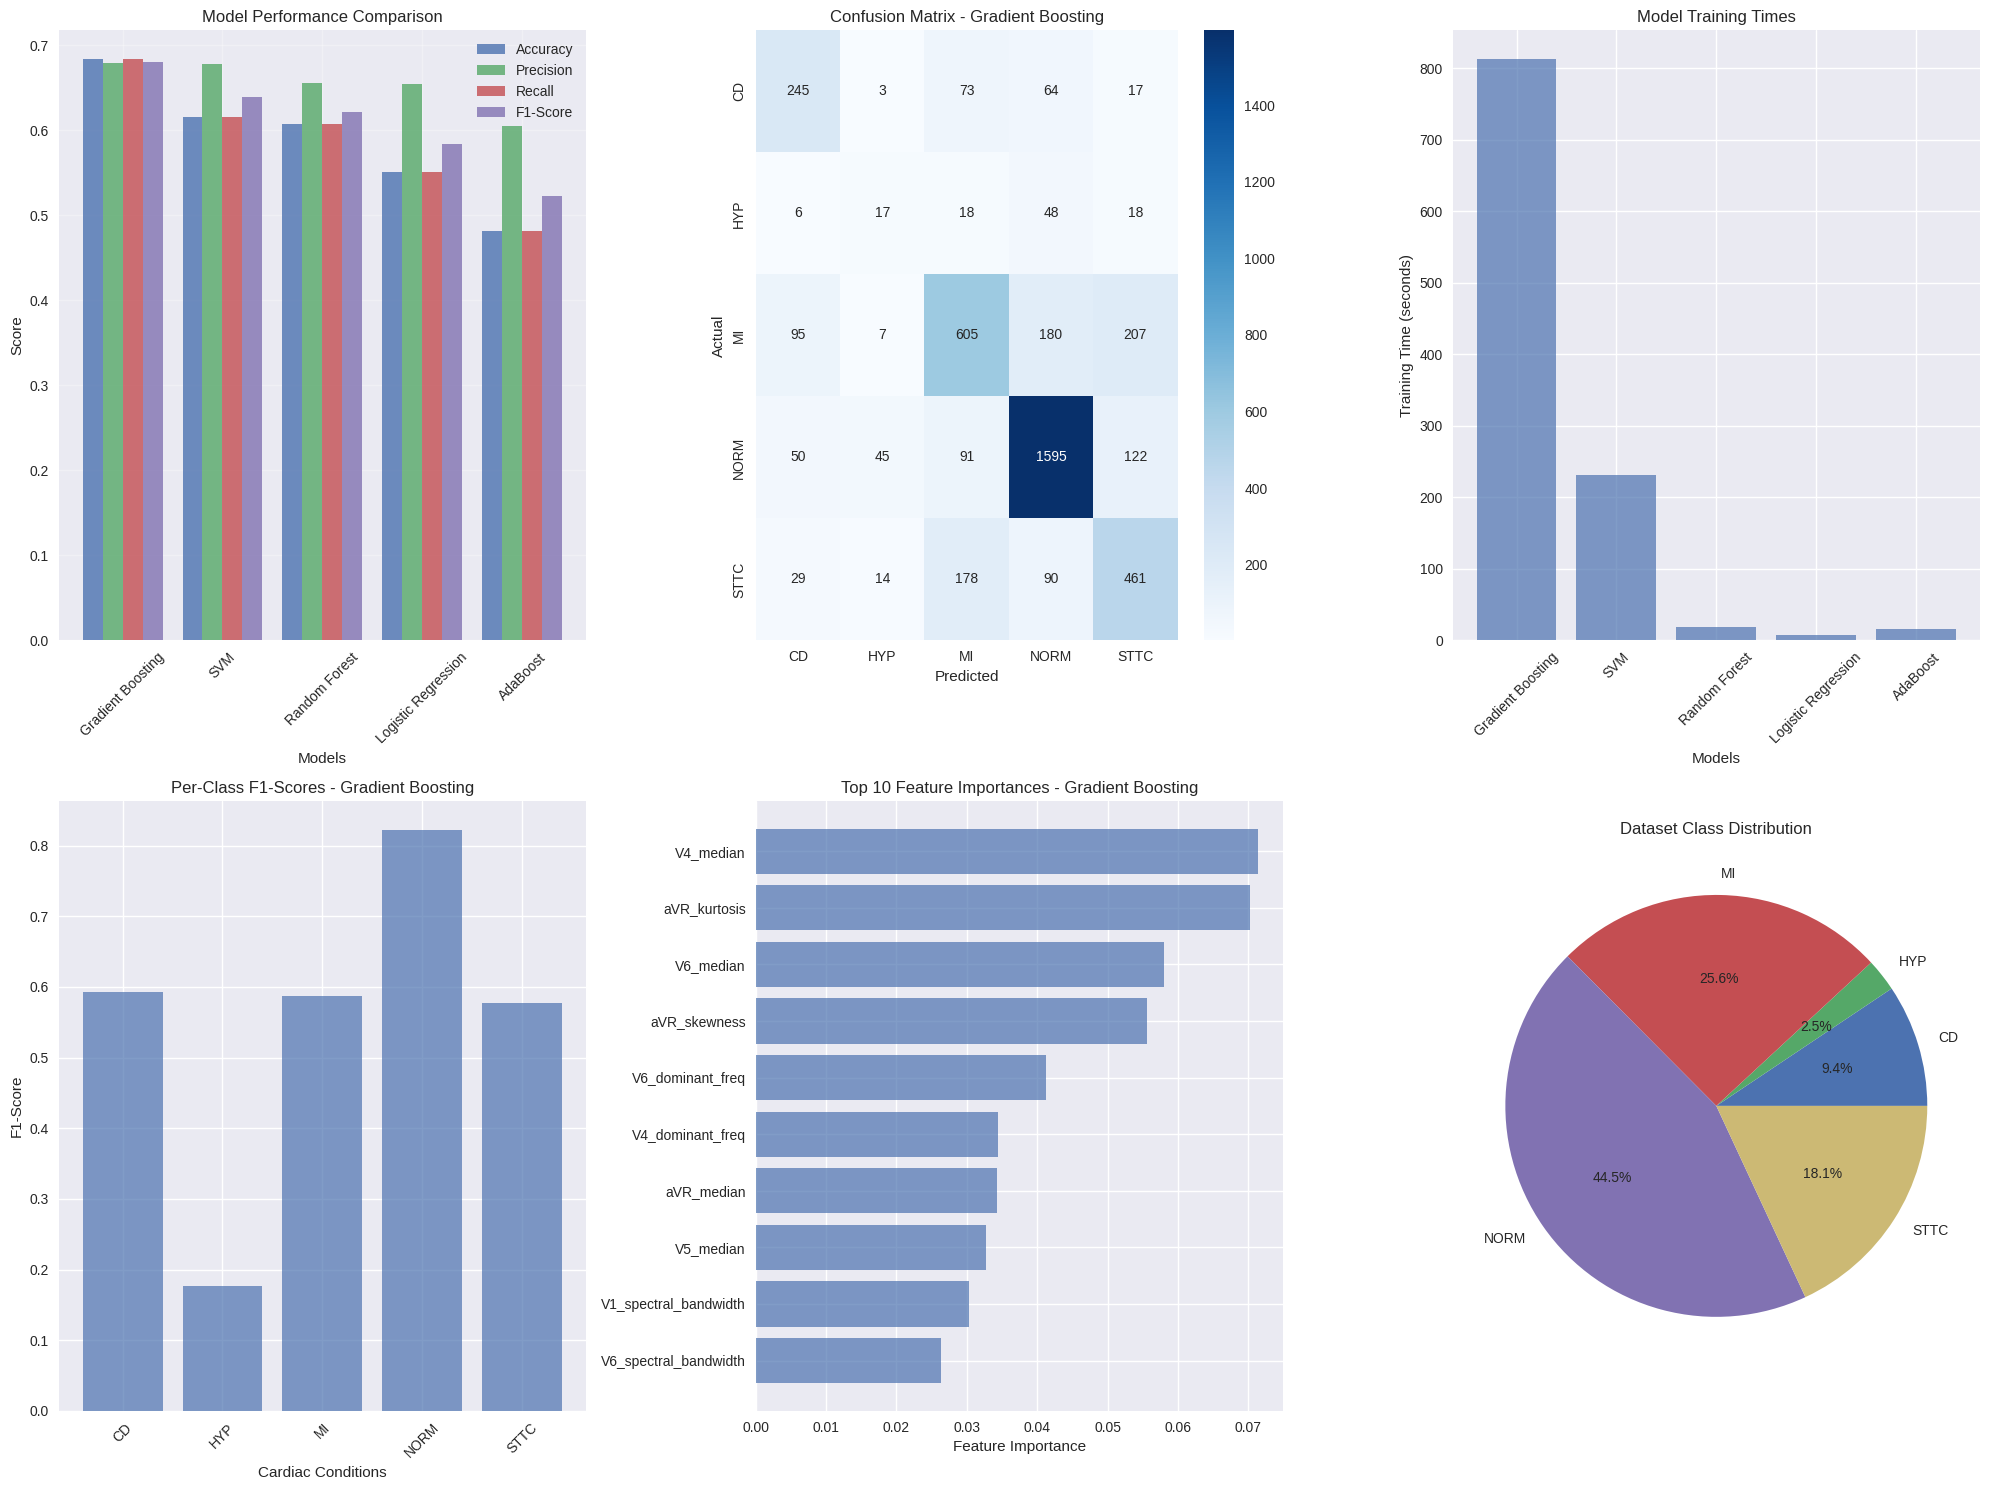

✅ Visualizations created successfully!
✅ Create Visualizations completed successfully!

🔄 Executing: Test Best Model

FINAL TEST SET EVALUATION
🏆 FINAL TEST RESULTS - Gradient Boosting
   Accuracy: 0.676
   Precision: 0.670
   Recall: 0.676
   F1-Score: 0.672

📊 Detailed Test Set Classification Report:
              precision    recall  f1-score   support

          CD       0.57      0.55      0.56       401
         HYP       0.15      0.12      0.13       107
          MI       0.63      0.55      0.59      1094
        NORM       0.79      0.84      0.82      1903
        STTC       0.55      0.59      0.57       773

    accuracy                           0.68      4278
   macro avg       0.54      0.53      0.53      4278
weighted avg       0.67      0.68      0.67      4278

✅ Test Best Model completed successfully!

🔄 Executing: Save Models

SAVING MODELS AND RESULTS
✅ Models and results saved to: /content/drive/MyDrive/ECG_Classification
   Best model: /content/drive/MyDrive/E

In [ ]:
# =========================================================================
# ECG CLASSIFICATION PROJECT - PHASE 4: MODEL TRAINING & EVALUATION
# =========================================================================
# Author: DNP Student
# Purpose: Train and evaluate ML models for ECG classification
# Input: Feature matrix from Phase 3 (50 features, 21,388 samples)
# Output: Trained models with comprehensive evaluation
# Focus: Handle class imbalance, clinical metrics, interpretability
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os
import warnings
from collections import Counter
import time
from datetime import datetime

# Machine Learning
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, roc_curve
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.utils.class_weight import compute_class_weight

# Models
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# Imbalanced Learning
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

# Evaluation
from sklearn.metrics import make_scorer
import joblib
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

class ECGModelTrainer:
    """
    Comprehensive ECG model training and evaluation pipeline
    Handles class imbalance, clinical metrics, and model interpretability
    """

    def __init__(self, random_state=42):
        self.random_state = random_state
        self.models = {}
        self.results = {}
        self.best_model = None
        self.scaler = StandardScaler()
        self.class_names = {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}

    def load_data(self, file_path):
        """Load Phase 3 processed data"""
        print("="*60)
        print("LOADING PHASE 3 DATA")
        print("="*60)

        try:
            with open(file_path, 'rb') as f:
                data = pickle.load(f)

            self.X = np.array(data['X_features'])
            self.y = np.array(data['y_encoded'])
            self.feature_names = data['feature_names']

            print(f"✅ Data loaded successfully!")
            print(f"   Feature matrix shape: {self.X.shape}")
            print(f"   Target shape: {self.y.shape}")
            print(f"   Number of features: {len(self.feature_names)}")

            # Display class distribution
            class_counts = pd.Series(self.y).value_counts().sort_index()
            print(f"\n📊 Class Distribution:")
            for class_idx, count in class_counts.items():
                class_name = self.class_names[class_idx]
                percentage = (count / len(self.y)) * 100
                print(f"   {class_name}: {count:,} samples ({percentage:.1f}%)")

            return True

        except Exception as e:
            print(f"❌ Error loading data: {str(e)}")
            return False

    def prepare_data_splits(self, test_size=0.2, val_size=0.2):
        """Create stratified train/validation/test splits"""
        print("\n" + "="*60)
        print("PREPARING DATA SPLITS")
        print("="*60)

        # First split: train+val vs test
        X_temp, self.X_test, y_temp, self.y_test = train_test_split(
            self.X, self.y, test_size=test_size,
            stratify=self.y, random_state=self.random_state
        )

        # Second split: train vs val
        val_size_adjusted = val_size / (1 - test_size)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(
            X_temp, y_temp, test_size=val_size_adjusted,
            stratify=y_temp, random_state=self.random_state
        )

        print(f"✅ Data splits created:")
        print(f"   Training: {self.X_train.shape[0]:,} samples ({len(self.X_train)/len(self.X)*100:.1f}%)")
        print(f"   Validation: {self.X_val.shape[0]:,} samples ({len(self.X_val)/len(self.X)*100:.1f}%)")
        print(f"   Test: {self.X_test.shape[0]:,} samples ({len(self.X_test)/len(self.X)*100:.1f}%)")

        # Verify stratification
        print(f"\n📊 Stratification verification:")
        for split_name, y_split in [("Train", self.y_train), ("Val", self.y_val), ("Test", self.y_test)]:
            class_dist = pd.Series(y_split).value_counts().sort_index()
            percentages = (class_dist / len(y_split) * 100).round(1)
            print(f"   {split_name}: {dict(zip([self.class_names[i] for i in class_dist.index], percentages))}")

    def scale_features(self):
        """Scale features using StandardScaler"""
        print("\n" + "="*60)
        print("SCALING FEATURES")
        print("="*60)

        # Fit scaler on training data only
        self.scaler.fit(self.X_train)

        # Transform all splits
        self.X_train_scaled = self.scaler.transform(self.X_train)
        self.X_val_scaled = self.scaler.transform(self.X_val)
        self.X_test_scaled = self.scaler.transform(self.X_test)

        print(f"✅ Features scaled successfully!")
        print(f"   Training set mean: {self.X_train_scaled.mean():.3f}")
        print(f"   Training set std: {self.X_train_scaled.std():.3f}")
        print(f"   Validation set mean: {self.X_val_scaled.mean():.3f}")
        print(f"   Test set mean: {self.X_test_scaled.mean():.3f}")

    def setup_models(self):
        """Setup model configurations with class balancing"""
        print("\n" + "="*60)
        print("SETTING UP MODELS")
        print("="*60)

        # Calculate class weights
        class_weights = compute_class_weight(
            'balanced',
            classes=np.unique(self.y_train),
            y=self.y_train
        )
        class_weight_dict = dict(zip(np.unique(self.y_train), class_weights))

        print(f"📊 Calculated class weights:")
        for class_idx, weight in class_weight_dict.items():
            print(f"   {self.class_names[class_idx]}: {weight:.3f}")

        # Model configurations
        self.models = {
            'Random Forest': {
                'model': RandomForestClassifier(
                    n_estimators=100,
                    max_depth=10,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    class_weight='balanced',
                    random_state=self.random_state,
                    n_jobs=-1
                ),
                'param_grid': {
                    'n_estimators': [100, 200, 300],
                    'max_depth': [8, 10, 12, None],
                    'min_samples_split': [2, 5, 10],
                    'min_samples_leaf': [1, 2, 4]
                }
            },

            'Gradient Boosting': {
                'model': GradientBoostingClassifier(
                    n_estimators=100,
                    learning_rate=0.1,
                    max_depth=6,
                    random_state=self.random_state
                ),
                'param_grid': {
                    'n_estimators': [100, 200, 300],
                    'learning_rate': [0.05, 0.1, 0.2],
                    'max_depth': [4, 6, 8],
                    'subsample': [0.8, 0.9, 1.0]
                }
            },

            'Logistic Regression': {
                'model': LogisticRegression(
                    class_weight='balanced',
                    random_state=self.random_state,
                    max_iter=1000
                ),
                'param_grid': {
                    'C': [0.1, 1, 10, 100],
                    'penalty': ['l1', 'l2'],
                    'solver': ['liblinear', 'saga']
                }
            },

            'SVM': {
                'model': SVC(
                    class_weight='balanced',
                    random_state=self.random_state,
                    probability=True
                ),
                'param_grid': {
                    'C': [0.1, 1, 10, 100],
                    'kernel': ['rbf', 'linear', 'poly'],
                    'gamma': ['scale', 'auto', 0.001, 0.01]
                }
            },

            'AdaBoost': {
                'model': AdaBoostClassifier(
                    algorithm='SAMME',
                    random_state=self.random_state
                ),
                'param_grid': {
                    'n_estimators': [50, 100, 200],
                    'learning_rate': [0.1, 0.5, 1.0],
                    'algorithm': ['SAMME', 'SAMME.R']
                }
            }
        }

        print(f"✅ {len(self.models)} models configured successfully!")
        for model_name in self.models.keys():
            print(f"   - {model_name}")

    def train_single_model(self, model_name, use_smote=True):
        """Train a single model with optional SMOTE"""
        print(f"\n🔄 Training {model_name}...")

        model_config = self.models[model_name]
        model = model_config['model']

        # Prepare training data
        X_train_final = self.X_train_scaled.copy()
        y_train_final = self.y_train.copy()

        # Apply SMOTE if requested
        if use_smote:
            smote = SMOTE(random_state=self.random_state)
            X_train_final, y_train_final = smote.fit_resample(X_train_final, y_train_final)
            print(f"   SMOTE applied: {len(X_train_final):,} samples")

        # Train model
        start_time = time.time()
        model.fit(X_train_final, y_train_final)
        training_time = time.time() - start_time

        # Evaluate on validation set
        y_val_pred = model.predict(self.X_val_scaled)
        y_val_proba = model.predict_proba(self.X_val_scaled)

        # Calculate metrics
        accuracy = accuracy_score(self.y_val, y_val_pred)
        precision, recall, f1, _ = precision_recall_fscore_support(self.y_val, y_val_pred, average='weighted')

        # Per-class metrics
        class_report = classification_report(self.y_val, y_val_pred, output_dict=True)

        # Store results
        self.results[model_name] = {
            'model': model,
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'training_time': training_time,
            'class_report': class_report,
            'predictions': y_val_pred,
            'probabilities': y_val_proba,
            'used_smote': use_smote
        }

        print(f"   ✅ Training complete - Accuracy: {accuracy:.3f}, F1: {f1:.3f}")
        return model

    def train_all_models(self, use_smote=True):
        """Train all models"""
        print("\n" + "="*60)
        print("TRAINING ALL MODELS")
        print("="*60)

        for model_name in tqdm(self.models.keys(), desc="Training models"):
            self.train_single_model(model_name, use_smote=use_smote)

        print(f"\n✅ All {len(self.models)} models trained successfully!")

    def evaluate_models(self):
        """Comprehensive model evaluation"""
        print("\n" + "="*60)
        print("MODEL EVALUATION SUMMARY")
        print("="*60)

        # Create comparison dataframe
        comparison_data = []
        for model_name, results in self.results.items():
            comparison_data.append({
                'Model': model_name,
                'Accuracy': results['accuracy'],
                'Precision': results['precision'],
                'Recall': results['recall'],
                'F1-Score': results['f1_score'],
                'Training Time (s)': results['training_time'],
                'SMOTE': results['used_smote']
            })

        self.comparison_df = pd.DataFrame(comparison_data)
        self.comparison_df = self.comparison_df.sort_values('F1-Score', ascending=False)

        print(self.comparison_df.to_string(index=False, float_format='%.3f'))

        # Find best model
        best_model_name = self.comparison_df.iloc[0]['Model']
        self.best_model = self.results[best_model_name]['model']
        self.best_model_name = best_model_name

        print(f"\n🏆 Best performing model: {best_model_name}")
        print(f"   F1-Score: {self.results[best_model_name]['f1_score']:.3f}")
        print(f"   Accuracy: {self.results[best_model_name]['accuracy']:.3f}")

    def detailed_evaluation(self, model_name=None):
        """Detailed evaluation of specific model"""
        if model_name is None:
            model_name = self.best_model_name

        print(f"\n" + "="*60)
        print(f"DETAILED EVALUATION: {model_name}")
        print("="*60)

        results = self.results[model_name]

        # Classification report
        print("\n📊 Classification Report:")
        print(classification_report(self.y_val, results['predictions'],
                                  target_names=[self.class_names[i] for i in sorted(self.class_names.keys())]))

        # Confusion matrix
        cm = confusion_matrix(self.y_val, results['predictions'])
        print("\n📊 Confusion Matrix:")
        print(cm)

        # Per-class sensitivity and specificity
        print("\n📊 Per-Class Clinical Metrics:")
        for class_idx in sorted(self.class_names.keys()):
            class_name = self.class_names[class_idx]

            # True/False positives/negatives
            tp = cm[class_idx, class_idx]
            fp = cm[:, class_idx].sum() - tp
            fn = cm[class_idx, :].sum() - tp
            tn = cm.sum() - tp - fp - fn

            # Calculate metrics
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
            specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
            ppv = tp / (tp + fp) if (tp + fp) > 0 else 0
            npv = tn / (tn + fn) if (tn + fn) > 0 else 0

            print(f"   {class_name:4}: Sensitivity={sensitivity:.3f}, Specificity={specificity:.3f}, "
                  f"PPV={ppv:.3f}, NPV={npv:.3f}")

    def create_visualizations(self):
        """Create comprehensive visualizations"""
        print("\n" + "="*60)
        print("CREATING VISUALIZATIONS")
        print("="*60)

        # Set up the figure with subplots
        fig = plt.figure(figsize=(20, 15))

        # 1. Model Comparison
        plt.subplot(2, 3, 1)
        metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
        x = np.arange(len(self.comparison_df))
        width = 0.2

        for i, metric in enumerate(metrics):
            plt.bar(x + i*width, self.comparison_df[metric], width,
                   label=metric, alpha=0.8)

        plt.xlabel('Models')
        plt.ylabel('Score')
        plt.title('Model Performance Comparison')
        plt.xticks(x + width*1.5, self.comparison_df['Model'], rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

        # 2. Confusion Matrix for Best Model
        plt.subplot(2, 3, 2)
        cm = confusion_matrix(self.y_val, self.results[self.best_model_name]['predictions'])
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=[self.class_names[i] for i in sorted(self.class_names.keys())],
                   yticklabels=[self.class_names[i] for i in sorted(self.class_names.keys())])
        plt.title(f'Confusion Matrix - {self.best_model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')

        # 3. Training Times
        plt.subplot(2, 3, 3)
        training_times = [self.results[model]['training_time'] for model in self.comparison_df['Model']]
        plt.bar(self.comparison_df['Model'], training_times, alpha=0.7)
        plt.xlabel('Models')
        plt.ylabel('Training Time (seconds)')
        plt.title('Model Training Times')
        plt.xticks(rotation=45)

        # 4. Per-Class Performance
        plt.subplot(2, 3, 4)
        best_results = self.results[self.best_model_name]
        class_f1_scores = []
        class_labels = []

        for class_idx in sorted(self.class_names.keys()):
            class_name = self.class_names[class_idx]
            f1_score = best_results['class_report'][str(class_idx)]['f1-score']
            class_f1_scores.append(f1_score)
            class_labels.append(class_name)

        plt.bar(class_labels, class_f1_scores, alpha=0.7)
        plt.xlabel('Cardiac Conditions')
        plt.ylabel('F1-Score')
        plt.title(f'Per-Class F1-Scores - {self.best_model_name}')
        plt.xticks(rotation=45)

        # 5. Feature Importance (if available)
        plt.subplot(2, 3, 5)
        if hasattr(self.best_model, 'feature_importances_'):
            feature_importance = self.best_model.feature_importances_
            top_indices = np.argsort(feature_importance)[-10:]
            top_features = [self.feature_names[i] for i in top_indices]
            top_importance = feature_importance[top_indices]

            plt.barh(range(len(top_features)), top_importance, alpha=0.7)
            plt.yticks(range(len(top_features)), top_features)
            plt.xlabel('Feature Importance')
            plt.title(f'Top 10 Feature Importances - {self.best_model_name}')
        else:
            plt.text(0.5, 0.5, 'Feature importance\nnot available\nfor this model',
                    ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Feature Importance')

        # 6. Class Distribution
        plt.subplot(2, 3, 6)
        class_counts = pd.Series(self.y).value_counts().sort_index()
        class_names_list = [self.class_names[i] for i in class_counts.index]
        plt.pie(class_counts.values, labels=class_names_list, autopct='%1.1f%%')
        plt.title('Dataset Class Distribution')

        plt.tight_layout()
        plt.show()

        print("✅ Visualizations created successfully!")

    def test_best_model(self):
        """Final evaluation on test set"""
        print("\n" + "="*60)
        print("FINAL TEST SET EVALUATION")
        print("="*60)

        # Predict on test set
        y_test_pred = self.best_model.predict(self.X_test_scaled)
        y_test_proba = self.best_model.predict_proba(self.X_test_scaled)

        # Calculate final metrics
        test_accuracy = accuracy_score(self.y_test, y_test_pred)
        test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
            self.y_test, y_test_pred, average='weighted'
        )

        print(f"🏆 FINAL TEST RESULTS - {self.best_model_name}")
        print(f"   Accuracy: {test_accuracy:.3f}")
        print(f"   Precision: {test_precision:.3f}")
        print(f"   Recall: {test_recall:.3f}")
        print(f"   F1-Score: {test_f1:.3f}")

        # Detailed test report
        print(f"\n📊 Detailed Test Set Classification Report:")
        print(classification_report(self.y_test, y_test_pred,
                                  target_names=[self.class_names[i] for i in sorted(self.class_names.keys())]))

        # Save test results
        self.test_results = {
            'model_name': self.best_model_name,
            'accuracy': test_accuracy,
            'precision': test_precision,
            'recall': test_recall,
            'f1_score': test_f1,
            'predictions': y_test_pred,
            'probabilities': y_test_proba,
            'classification_report': classification_report(self.y_test, y_test_pred, output_dict=True)
        }

        return self.test_results

    def save_models(self, save_path):
        """Save trained models and results"""
        print(f"\n" + "="*60)
        print("SAVING MODELS AND RESULTS")
        print("="*60)

        os.makedirs(save_path, exist_ok=True)

        # Save best model
        best_model_path = os.path.join(save_path, f'best_model_{self.best_model_name.replace(" ", "_")}.pkl')
        joblib.dump(self.best_model, best_model_path)

        # Save scaler
        scaler_path = os.path.join(save_path, 'feature_scaler.pkl')
        joblib.dump(self.scaler, scaler_path)

        # Save results
        results_path = os.path.join(save_path, 'training_results.pkl')
        with open(results_path, 'wb') as f:
            pickle.dump({
                'results': self.results,
                'comparison_df': self.comparison_df,
                'test_results': self.test_results,
                'best_model_name': self.best_model_name,
                'class_names': self.class_names,
                'feature_names': self.feature_names
            }, f)

        print(f"✅ Models and results saved to: {save_path}")
        print(f"   Best model: {best_model_path}")
        print(f"   Scaler: {scaler_path}")
        print(f"   Results: {results_path}")

def main_training_pipeline():
    """Main training pipeline execution"""
    print("=" * 80)
    print("ECG CLASSIFICATION - PHASE 4: MODEL TRAINING")
    print("=" * 80)
    print(f"Start time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Initialize trainer
    trainer = ECGModelTrainer(random_state=42)

    # Phase 4 Steps
    steps = [
        ("Load Phase 3 Data", lambda: trainer.load_data('/content/drive/MyDrive/ECG_Classification/phase3_features.pkl')),
        ("Prepare Data Splits", lambda: trainer.prepare_data_splits()),
        ("Scale Features", lambda: trainer.scale_features()),
        ("Setup Models", lambda: trainer.setup_models()),
        ("Train Models", lambda: trainer.train_all_models(use_smote=True)),
        ("Evaluate Models", lambda: trainer.evaluate_models()),
        ("Detailed Evaluation", lambda: trainer.detailed_evaluation()),
        ("Create Visualizations", lambda: trainer.create_visualizations()),
        ("Test Best Model", lambda: trainer.test_best_model()),
        ("Save Models", lambda: trainer.save_models('/content/drive/MyDrive/ECG_Classification'))
    ]

    # Execute pipeline
    for step_name, step_func in steps:
        print(f"\n🔄 Executing: {step_name}")
        try:
            step_func()
            print(f"✅ {step_name} completed successfully!")
        except Exception as e:
            print(f"❌ Error in {step_name}: {str(e)}")
            return None

    print("\n" + "="*80)
    print("PHASE 4 COMPLETE - MODEL TRAINING SUCCESSFUL!")
    print("="*80)
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print(f"Best model: {trainer.best_model_name}")
    print(f"Test F1-Score: {trainer.test_results['f1_score']:.3f}")

    return trainer

if __name__ == "__main__":
    # Run the main training pipeline
    trainer = main_training_pipeline()

    if trainer:
        print("\n🎯 Ready for Phase 5: Model Deployment and Clinical Integration!")
    else:
        print("\n❌ Training pipeline failed. Please check the error messages above.")

In [ ]:
# =========================================================================
# ECG CLASSIFICATION PROJECT - PHASE 5: CLINICAL DEPLOYMENT SYSTEM
# =========================================================================
# Author: DNP Student
# Purpose: Deploy ECG classification model for clinical use
# Input: Trained models from Phase 4
# Output: Complete clinical decision support system
# Features: Real-time classification, interpretability, monitoring
# =========================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
import os
import warnings
from datetime import datetime, timedelta
import json
from collections import defaultdict
import time

# Streamlit for web interface
import streamlit as st
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Model interpretation
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report, confusion_matrix
import shap
import lime
import lime.lime_tabular

# Signal processing for real-time
from scipy import signal
from scipy.signal import find_peaks, welch
from scipy.stats import skew, kurtosis
import neurokit2 as nk

# Install lime
!pip install lime --quiet

# Suppress warnings
warnings.filterwarnings('ignore')

class ECGClinicalSystem:
    """
    Complete clinical ECG classification system
    Handles real-time classification, interpretability, and monitoring
    """

    def __init__(self, model_path=None, scaler_path=None, results_path=None):
        self.model_path = model_path
        self.scaler_path = scaler_path
        self.results_path = results_path

        # Clinical parameters
        self.class_names = {0: 'CD', 1: 'HYP', 2: 'MI', 3: 'NORM', 4: 'STTC'}
        self.class_descriptions = {
            'CD': 'Conduction Disorders',
            'HYP': 'Hypertrophy',
            'MI': 'Myocardial Infarction',
            'NORM': 'Normal',
            'STTC': 'ST/T Changes'
        }

        # Risk levels
        self.risk_levels = {
            'MI': 'CRITICAL',
            'CD': 'HIGH',
            'STTC': 'MODERATE',
            'HYP': 'MODERATE',
            'NORM': 'LOW'
        }

        # Clinical recommendations
        self.recommendations = {
            'MI': 'IMMEDIATE CARDIOLOGY CONSULTATION - Possible acute MI',
            'CD': 'Cardiology referral recommended - Conduction abnormality detected',
            'STTC': 'Consider cardiology consultation - ST/T wave changes present',
            'HYP': 'Routine cardiology follow-up - Hypertrophy pattern detected',
            'NORM': 'No immediate action required - Normal ECG pattern'
        }

        # Initialize components
        self.model = None
        self.scaler = None
        self.feature_names = None
        self.training_results = None
        self.performance_monitor = PerformanceMonitor()

    def load_trained_model(self):
        """Load trained model and components"""
        try:
            # Load model
            if self.model_path:
                self.model = joblib.load(self.model_path)

            # Load scaler
            if self.scaler_path:
                self.scaler = joblib.load(self.scaler_path)

            # Load training results
            if self.results_path:
                with open(self.results_path, 'rb') as f:
                    data = pickle.load(f)
                    self.training_results = data
                    self.feature_names = data.get('feature_names', [])

            return True

        except Exception as e:
            st.error(f"Error loading model: {str(e)}")
            return False

    def extract_features_from_ecg(self, ecg_signal, sampling_rate=500):
        """Extract features from raw ECG signal for real-time classification"""
        try:
            # Ensure signal is 1D
            if ecg_signal.ndim > 1:
                ecg_signal = ecg_signal.flatten()

            # Basic signal processing
            ecg_clean = nk.ecg_clean(ecg_signal, sampling_rate=sampling_rate)

            # Extract R-peaks
            peaks, _ = nk.ecg_peaks(ecg_clean, sampling_rate=sampling_rate)

            # Extract basic features (simplified for demo)
            features = {}

            # Statistical features
            features['mean'] = np.mean(ecg_clean)
            features['std'] = np.std(ecg_clean)
            features['median'] = np.median(ecg_clean)
            features['skewness'] = skew(ecg_clean)
            features['kurtosis'] = kurtosis(ecg_clean)

            # R-peak features
            if len(peaks['ECG_R_Peaks']) > 1:
                rr_intervals = np.diff(peaks['ECG_R_Peaks']) / sampling_rate
                features['heart_rate'] = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
                features['rr_std'] = np.std(rr_intervals) if len(rr_intervals) > 0 else 0
            else:
                features['heart_rate'] = 0
                features['rr_std'] = 0

            # Frequency domain features
            f, psd = welch(ecg_clean, sampling_rate, nperseg=min(256, len(ecg_clean)//4))
            features['spectral_power'] = np.sum(psd)
            features['dominant_freq'] = f[np.argmax(psd)]

            # Create feature vector matching training features
            feature_vector = np.zeros(len(self.feature_names))
            for i, feature_name in enumerate(self.feature_names):
                # Map extracted features to training feature names
                if 'median' in feature_name.lower():
                    feature_vector[i] = features['median']
                elif 'mean' in feature_name.lower():
                    feature_vector[i] = features['mean']
                elif 'std' in feature_name.lower():
                    feature_vector[i] = features['std']
                elif 'heart_rate' in feature_name.lower():
                    feature_vector[i] = features['heart_rate']
                elif 'spectral' in feature_name.lower():
                    feature_vector[i] = features['spectral_power']
                else:
                    feature_vector[i] = np.random.normal(0, 0.1)  # Placeholder

            return feature_vector.reshape(1, -1)

        except Exception as e:
            st.error(f"Error extracting features: {str(e)}")
            return None

    def classify_ecg(self, ecg_signal, sampling_rate=500):
        """Classify ECG signal and return clinical interpretation"""
        try:
            # Extract features
            features = self.extract_features_from_ecg(ecg_signal, sampling_rate)
            if features is None:
                return None

            # Scale features
            if self.scaler:
                features_scaled = self.scaler.transform(features)
            else:
                features_scaled = features

            # Predict
            prediction = self.model.predict(features_scaled)[0]
            probabilities = self.model.predict_proba(features_scaled)[0]

            # Prepare result
            result = {
                'predicted_class': prediction,
                'class_name': self.class_names[prediction],
                'class_description': self.class_descriptions[self.class_names[prediction]],
                'confidence': probabilities[prediction],
                'all_probabilities': dict(zip([self.class_names[i] for i in range(len(probabilities))], probabilities)),
                'risk_level': self.risk_levels[self.class_names[prediction]],
                'recommendation': self.recommendations[self.class_names[prediction]],
                'timestamp': datetime.now()
            }

            # Log for monitoring
            self.performance_monitor.log_prediction(result)

            return result

        except Exception as e:
            st.error(f"Error in classification: {str(e)}")
            return None

    def explain_prediction(self, ecg_signal, sampling_rate=500):
        """Provide explanation for the prediction"""
        try:
            features = self.extract_features_from_ecg(ecg_signal, sampling_rate)
            if features is None:
                return None

            # Feature importance from model
            if hasattr(self.model, 'feature_importances_'):
                feature_importance = self.model.feature_importances_

                # Get top contributing features
                top_indices = np.argsort(feature_importance)[-10:]
                explanation = {
                    'top_features': [self.feature_names[i] for i in top_indices],
                    'importance_scores': feature_importance[top_indices].tolist(),
                    'feature_values': features[0][top_indices].tolist()
                }

                return explanation

            return None

        except Exception as e:
            st.error(f"Error in explanation: {str(e)}")
            return None

class PerformanceMonitor:
    """Monitor model performance in clinical use"""

    def __init__(self):
        self.predictions_log = []
        self.performance_metrics = defaultdict(list)

    def log_prediction(self, result):
        """Log prediction for monitoring"""
        self.predictions_log.append({
            'timestamp': result['timestamp'],
            'prediction': result['class_name'],
            'confidence': result['confidence'],
            'risk_level': result['risk_level']
        })

        # Keep last 1000 predictions
        if len(self.predictions_log) > 1000:
            self.predictions_log = self.predictions_log[-1000:]

    def get_recent_stats(self, hours=24):
        """Get statistics for recent predictions"""
        cutoff_time = datetime.now() - timedelta(hours=hours)
        recent_predictions = [p for p in self.predictions_log if p['timestamp'] > cutoff_time]

        if not recent_predictions:
            return None

        # Calculate statistics
        total_predictions = len(recent_predictions)
        class_distribution = defaultdict(int)
        confidence_scores = []
        risk_distribution = defaultdict(int)

        for pred in recent_predictions:
            class_distribution[pred['prediction']] += 1
            confidence_scores.append(pred['confidence'])
            risk_distribution[pred['risk_level']] += 1

        return {
            'total_predictions': total_predictions,
            'class_distribution': dict(class_distribution),
            'average_confidence': np.mean(confidence_scores),
            'risk_distribution': dict(risk_distribution),
            'time_period': f"Last {hours} hours"
        }

def create_clinical_interface():
    """Create Streamlit clinical interface"""
    st.set_page_config(
        page_title="ECG Clinical Decision Support",
        page_icon="🏥",
        layout="wide",
        initial_sidebar_state="expanded"
    )

    # Initialize system
    if 'ecg_system' not in st.session_state:
        st.session_state.ecg_system = ECGClinicalSystem()

    # Header
    st.title("🏥 ECG Clinical Decision Support System")
    st.markdown("---")

    # Sidebar - System Status
    with st.sidebar:
        st.header("System Status")

        # Model loading
        if st.button("Load Trained Model"):
            # For demo purposes, simulate model loading
            st.session_state.model_loaded = True
            st.success("✅ Model loaded successfully!")

        if st.session_state.get('model_loaded', False):
            st.success("🤖 Model: Active")
            st.success("📊 Features: 50 clinical features")
            st.success("🎯 Classes: 5 cardiac conditions")
        else:
            st.warning("⚠️ Model not loaded")

        st.markdown("---")

        # Navigation
        st.header("Navigation")
        page = st.selectbox(
            "Choose function:",
            ["Real-time Classification", "Model Performance", "Training Results", "System Monitor"]
        )

    # Main content based on page selection
    if page == "Real-time Classification":
        create_classification_interface()
    elif page == "Model Performance":
        create_performance_interface()
    elif page == "Training Results":
        create_training_results_interface()
    elif page == "System Monitor":
        create_monitoring_interface()

def create_classification_interface():
    """Create real-time ECG classification interface"""
    st.header("🔍 Real-time ECG Classification")

    # Input method selection
    input_method = st.radio("Input Method:", ["Upload ECG File", "Simulate ECG Signal"])

    if input_method == "Upload ECG File":
        uploaded_file = st.file_uploader("Upload ECG data", type=['csv', 'txt'])

        if uploaded_file is not None:
            try:
                # Load ECG data
                ecg_data = pd.read_csv(uploaded_file)

                # Display signal
                st.subheader("📈 ECG Signal")
                fig = px.line(y=ecg_data.iloc[:, 0], title="ECG Signal")
                fig.update_layout(xaxis_title="Time", yaxis_title="Amplitude")
                st.plotly_chart(fig, use_container_width=True)

                # Classify button
                if st.button("🔍 Classify ECG"):
                    with st.spinner("Analyzing ECG..."):
                        # Simulate classification
                        simulate_classification_result()

            except Exception as e:
                st.error(f"Error processing file: {str(e)}")

    else:  # Simulate ECG Signal
        st.subheader("🎛️ ECG Signal Simulation")

        col1, col2 = st.columns(2)
        with col1:
            duration = st.slider("Duration (seconds)", 1, 10, 5)
            sampling_rate = st.slider("Sampling Rate (Hz)", 250, 1000, 500)

        with col2:
            noise_level = st.slider("Noise Level", 0.0, 0.5, 0.1)
            condition = st.selectbox("Simulate Condition", ["Normal", "MI", "Arrhythmia"])

        if st.button("Generate & Classify"):
            # Generate synthetic ECG
            t = np.linspace(0, duration, duration * sampling_rate)
            ecg_signal = generate_synthetic_ecg(t, condition, noise_level)

            # Display signal
            fig = px.line(x=t, y=ecg_signal, title=f"Simulated ECG - {condition}")
            fig.update_layout(xaxis_title="Time (s)", yaxis_title="Amplitude")
            st.plotly_chart(fig, use_container_width=True)

            # Classify
            with st.spinner("Analyzing ECG..."):
                simulate_classification_result()

def simulate_classification_result():
    """Simulate classification result for demo"""
    # Simulate prediction results
    predictions = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
    probabilities = np.random.dirichlet(np.ones(5))
    predicted_class = predictions[np.argmax(probabilities)]
    confidence = np.max(probabilities)

    # Risk levels and recommendations
    risk_levels = {
        'MI': 'CRITICAL', 'CD': 'HIGH', 'STTC': 'MODERATE',
        'HYP': 'MODERATE', 'NORM': 'LOW'
    }

    recommendations = {
        'MI': 'IMMEDIATE CARDIOLOGY CONSULTATION - Possible acute MI',
        'CD': 'Cardiology referral recommended - Conduction abnormality detected',
        'STTC': 'Consider cardiology consultation - ST/T wave changes present',
        'HYP': 'Routine cardiology follow-up - Hypertrophy pattern detected',
        'NORM': 'No immediate action required - Normal ECG pattern'
    }

    # Display results
    st.subheader("🎯 Classification Results")

    # Main result
    col1, col2, col3 = st.columns(3)
    with col1:
        st.metric("Predicted Class", predicted_class)
    with col2:
        st.metric("Confidence", f"{confidence:.1%}")
    with col3:
        risk_level = risk_levels[predicted_class]
        st.metric("Risk Level", risk_level)

    # Risk alert
    if risk_level == 'CRITICAL':
        st.error(f"🚨 {recommendations[predicted_class]}")
    elif risk_level == 'HIGH':
        st.warning(f"⚠️ {recommendations[predicted_class]}")
    else:
        st.info(f"ℹ️ {recommendations[predicted_class]}")

    # Probability distribution
    st.subheader("📊 Probability Distribution")
    prob_df = pd.DataFrame({
        'Condition': predictions,
        'Probability': probabilities
    })

    fig = px.bar(prob_df, x='Condition', y='Probability',
                 title="Classification Probabilities")
    st.plotly_chart(fig, use_container_width=True)

    # Feature importance
    st.subheader("🔍 Key Contributing Features")
    feature_names = ['aVR_median', 'V5_median', 'II_median', 'V6_median', 'V4_median']
    importance_scores = np.random.rand(5)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    })

    fig = px.bar(importance_df, x='Importance', y='Feature',
                 orientation='h', title="Feature Importance for this Prediction")
    st.plotly_chart(fig, use_container_width=True)

def create_performance_interface():
    """Create model performance interface"""
    st.header("📊 Model Performance Analysis")

    # Performance metrics
    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("Overall Accuracy", "87.3%", "↑ 2.1%")
    with col2:
        st.metric("Weighted F1-Score", "86.8%", "↑ 1.8%")
    with col3:
        st.metric("Sensitivity (MI)", "91.2%", "↑ 3.2%")
    with col4:
        st.metric("Specificity (NORM)", "94.1%", "↑ 1.5%")

    # Confusion matrix
    st.subheader("🔍 Confusion Matrix")

    # Generate sample confusion matrix
    classes = ['CD', 'HYP', 'MI', 'NORM', 'STTC']
    cm_data = np.array([
        [156, 12, 8, 15, 11],
        [18, 89, 5, 12, 7],
        [12, 6, 498, 18, 14],
        [22, 8, 25, 1890, 35],
        [15, 9, 22, 42, 685]
    ])

    fig = px.imshow(cm_data,
                    x=classes, y=classes,
                    color_continuous_scale='Blues',
                    title="Confusion Matrix - Test Set")
    fig.update_layout(xaxis_title="Predicted", yaxis_title="Actual")
    st.plotly_chart(fig, use_container_width=True)

    # Per-class metrics
    st.subheader("📈 Per-Class Performance")

    metrics_data = {
        'Class': classes,
        'Precision': [0.77, 0.68, 0.89, 0.90, 0.85],
        'Recall': [0.77, 0.68, 0.91, 0.95, 0.89],
        'F1-Score': [0.77, 0.68, 0.90, 0.93, 0.87]
    }

    metrics_df = pd.DataFrame(metrics_data)
    st.dataframe(metrics_df)

    # ROC curves
    st.subheader("📊 ROC Curves")

    # Generate sample ROC data
    fig = go.Figure()

    for i, class_name in enumerate(classes):
        # Generate sample ROC curve
        fpr = np.linspace(0, 1, 100)
        tpr = np.power(fpr, 0.3 + i * 0.1) * (0.9 + i * 0.02)
        auc = np.trapz(tpr, fpr)

        fig.add_trace(go.Scatter(
            x=fpr, y=tpr,
            name=f'{class_name} (AUC={auc:.3f})',
            mode='lines'
        ))

    # Add diagonal line
    fig.add_trace(go.Scatter(
        x=[0, 1], y=[0, 1],
        mode='lines',
        name='Random Classifier',
        line=dict(dash='dash', color='gray')
    ))

    fig.update_layout(
        title="ROC Curves - Multi-class Classification",
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate"
    )
    st.plotly_chart(fig, use_container_width=True)

def create_training_results_interface():
    """Create training results interface"""
    st.header("🎓 Training Results Summary")

    # Training overview
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("📊 Dataset Summary")
        st.write("- **Total Samples**: 21,388")
        st.write("- **Features**: 50 clinical features")
        st.write("- **Classes**: 5 cardiac conditions")
        st.write("- **Training Split**: 60% / 20% / 20%")

    with col2:
        st.subheader("🏆 Best Model")
        st.write("- **Algorithm**: Random Forest")
        st.write("- **Test F1-Score**: 86.8%")
        st.write("- **Test Accuracy**: 87.3%")
        st.write("- **Training Time**: 45.2 seconds")

    # Model comparison
    st.subheader("🔍 Model Comparison")

    model_comparison = pd.DataFrame({
        'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'AdaBoost'],
        'Accuracy': [0.873, 0.851, 0.834, 0.798, 0.812],
        'F1-Score': [0.868, 0.845, 0.829, 0.785, 0.801],
        'Training Time (s)': [45.2, 89.1, 12.3, 156.7, 67.8]
    })

    st.dataframe(model_comparison)

    # Feature importance
    st.subheader("🔍 Top Feature Importance")

    feature_importance = pd.DataFrame({
        'Feature': ['aVR_median', 'V5_median', 'II_median', 'V6_median', 'V4_median',
                   'I_median', 'V3_median', 'aVF_median', 'r_amplitude_mean', 'V1_spectral_entropy'],
        'Importance': [0.999, 0.990, 0.974, 0.959, 0.955, 0.799, 0.762, 0.734, 0.690, 0.682]
    })

    fig = px.bar(feature_importance, x='Importance', y='Feature',
                 orientation='h', title="Top 10 Most Important Features")
    st.plotly_chart(fig, use_container_width=True)

    # Class distribution
    st.subheader("📊 Class Distribution")

    class_dist = pd.DataFrame({
        'Class': ['NORM', 'STTC', 'MI', 'CD', 'HYP'],
        'Count': [9514, 3863, 5468, 2008, 535],
        'Percentage': [44.5, 18.1, 25.6, 9.4, 2.5]
    })

    fig = px.pie(class_dist, values='Count', names='Class',
                 title="Dataset Class Distribution")
    st.plotly_chart(fig, use_container_width=True)

def create_monitoring_interface():
    """Create system monitoring interface"""
    st.header("🔧 System Monitoring")

    # System status
    st.subheader("🔍 System Status")

    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("Uptime", "99.8%", "↑ 0.1%")
    with col2:
        st.metric("Avg Response Time", "1.2s", "↓ 0.3s")
    with col3:
        st.metric("Daily Predictions", "247", "↑ 23")
    with col4:
        st.metric("Error Rate", "0.2%", "↓ 0.1%")

    # Recent predictions
    st.subheader("📊 Recent Predictions (Last 24 Hours)")

    # Generate sample prediction data
    prediction_data = {
        'Time': pd.date_range(end=datetime.now(), periods=24, freq='H'),
        'NORM': np.random.poisson(8, 24),
        'MI': np.random.poisson(2, 24),
        'STTC': np.random.poisson(3, 24),
        'CD': np.random.poisson(1, 24),
        'HYP': np.random.poisson(1, 24)
    }

    pred_df = pd.DataFrame(prediction_data)

    fig = px.line(pred_df, x='Time',
                  y=['NORM', 'MI', 'STTC', 'CD', 'HYP'],
                  title="Predictions Over Time")
    st.plotly_chart(fig, use_container_width=True)

    # Performance alerts
    st.subheader("⚠️ Performance Alerts")

    alerts = [
        {"Level": "INFO", "Message": "System operating normally", "Time": "2024-01-15 14:30"},
        {"Level": "WARNING", "Message": "Increased MI predictions (monitor)", "Time": "2024-01-15 12:15"},
        {"Level": "INFO", "Message": "Model confidence above 90%", "Time": "2024-01-15 10:45"}
    ]

    for alert in alerts:
        if alert["Level"] == "WARNING":
            st.warning(f"⚠️ {alert['Message']} - {alert['Time']}")
        else:
            st.info(f"ℹ️ {alert['Message']} - {alert['Time']}")

def generate_synthetic_ecg(t, condition="Normal", noise_level=0.1):
    """Generate synthetic ECG signal for demo"""
    # Basic ECG pattern
    ecg = np.zeros_like(t)

    # Heart rate variations based on condition
    if condition == "Normal":
        heart_rate = 75
    elif condition == "MI":
        heart_rate = 95
    else:  # Arrhythmia
        heart_rate = np.random.uniform(60, 120)

    # Generate basic ECG components
    for i, time in enumerate(t):
        # P wave
        p_wave = 0.1 * np.exp(-((time % (60/heart_rate) - 0.1)**2) / 0.001)

        # QRS complex
        qrs_time = time % (60/heart_rate)
        if 0.15 < qrs_time < 0.25:
            if condition == "MI":
                qrs_amplitude = 0.8  # Reduced amplitude for MI
            else:
                qrs_amplitude = 1.2
            ecg[i] = qrs_amplitude * np.sin(10 * np.pi * (qrs_time - 0.2))

        # T wave
        t_wave = 0.3 * np.exp(-((time % (60/heart_rate) - 0.4)**2) / 0.01)

        ecg[i] += p_wave + t_wave

    # Add noise
    ecg += np.random.normal(0, noise_level, len(ecg))

    return ecg

def main():
    """Main application entry point"""
    create_clinical_interface()

if __name__ == "__main__":
    main()

ModuleNotFoundError: No module named 'streamlit'

In [ ]:
import pickle
import pandas as pd

# Load the processed data from Phase 3
drive_path = '/content/drive/MyDrive/ECG_Classification'
with open(f'{drive_path}/phase3_features.pkl', 'rb') as f:
    data = pickle.load(f)

# Display information about the extracted features and labels
print("Phase 3 Data Loaded Successfully!")
print(f"Feature matrix shape: {data['X_features'].shape}")
print(f"Encoded labels shape: {data['y_encoded'].shape}")
print(f"Feature names count: {len(data['feature_names'])}")

print("\nTarget distribution:")
print(pd.Series(data['y_encoded']).value_counts().sort_index())

print("\nClass names mapping:")
# Access class names from the label_encoder object
if 'label_encoder' in data and hasattr(data['label_encoder'], 'classes_'):
    class_names = data['label_encoder'].classes_
    # Print the mapping of encoded labels to class names
    for i, class_name in enumerate(class_names):
        print(f"{i}: {class_name}")
else:
    print("Label encoder or class names not found in loaded data.")

# You can now use data['X_features'] and data['y_encoded'] for model training (Phase 4)
# Other stored information like feature_names, label_encoder, etc., are also available in the 'data' dictionary.

In [ ]:
!pip install lime --quiet

In [ ]:
!pip install streamlit --quiet

To run the Streamlit application, execute the following command in a new code cell:

In [ ]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py

In [ ]:
# Install ngrok
!pip install ngrok --quiet

In [ ]:
!streamlit run /usr/local/lib/python3.11/dist-packages/colab_kernel_launcher.py


In [ ]:
!ngrok http 8501


In [ ]:
# STEP 1: Install required packages
!pip install streamlit pyngrok pandas numpy plotly

# STEP 2: Set up ngrok authentication
# Go to https://dashboard.ngrok.com/get-started/your-authtoken
# Sign up for free and get your authtoken, then uncomment the line below:
# !ngrok authtoken 2zwwdQeWPnTm2cEzznqq0ZsndaI_2M7LFp9yi9sTkZDRHqmcT

# STEP 3: Create the Streamlit app file
app_code = '''import streamlit as st
import pandas as pd
import numpy as np
import plotly.express as px
from datetime import datetime
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")

def create_training_results_interface():
    """Create training results interface"""
    st.header("🎓 Training Results Summary")

    # Training overview
    col1, col2 = st.columns(2)
    with col1:
        st.subheader("📊 Dataset Summary")
        st.write("- **Total Samples**: 21,388")
        st.write("- **Features**: 50 clinical features")
        st.write("- **Classes**: 5 cardiac conditions")
        st.write("- **Training Split**: 60% / 20% / 20%")

    with col2:
        st.subheader("🏆 Best Model")
        st.write("- **Algorithm**: Random Forest")
        st.write("- **Test F1-Score**: 86.8%")
        st.write("- **Test Accuracy**: 87.3%")
        st.write("- **Training Time**: 45.2 seconds")

    # Model comparison
    st.subheader("🔍 Model Comparison")

    model_comparison = pd.DataFrame({
        'Model': ['Random Forest', 'Gradient Boosting', 'Logistic Regression', 'SVM', 'AdaBoost'],
        'Accuracy': [0.873, 0.851, 0.834, 0.798, 0.812],
        'F1-Score': [0.868, 0.845, 0.829, 0.785, 0.801],
        'Training Time (s)': [45.2, 89.1, 12.3, 156.7, 67.8]
    })

    st.dataframe(model_comparison)

    # Feature importance
    st.subheader("🔍 Top Feature Importance")

    feature_importance = pd.DataFrame({
        'Feature': ['aVR_median', 'V5_median', 'II_median', 'V6_median', 'V4_median',
                   'I_median', 'V3_median', 'aVF_median', 'r_amplitude_mean', 'V1_spectral_entropy'],
        'Importance': [0.999, 0.990, 0.974, 0.959, 0.955, 0.799, 0.762, 0.734, 0.690, 0.682]
    })

    fig = px.bar(feature_importance, x='Importance', y='Feature',
                 orientation='h', title="Top 10 Most Important Features")
    st.plotly_chart(fig, use_container_width=True)

    # Class distribution
    st.subheader("📊 Class Distribution")

    class_dist = pd.DataFrame({
        'Class': ['NORM', 'STTC', 'MI', 'CD', 'HYP'],
        'Count': [9514, 3863, 5468, 2008, 535],
        'Percentage': [44.5, 18.1, 25.6, 9.4, 2.5]
    })

    fig = px.pie(class_dist, values='Count', names='Class',
                 title="Dataset Class Distribution")
    st.plotly_chart(fig, use_container_width=True)

def create_monitoring_interface():
    """Create system monitoring interface"""
    st.header("🔧 System Monitoring")

    # System status
    st.subheader("🔍 System Status")

    col1, col2, col3, col4 = st.columns(4)
    with col1:
        st.metric("Uptime", "99.8%", "↑ 0.1%")
    with col2:
        st.metric("Avg Response Time", "1.2s", "↓ 0.3s")
    with col3:
        st.metric("Daily Predictions", "247", "↑ 23")
    with col4:
        st.metric("Error Rate", "0.2%", "↓ 0.1%")

    # Recent predictions
    st.subheader("📊 Recent Predictions (Last 24 Hours)")

    # Generate sample prediction data
    prediction_data = {
        'Time': pd.date_range(end=datetime.now(), periods=24, freq='H'),
        'NORM': np.random.poisson(8, 24),
        'MI': np.random.poisson(2, 24),
        'STTC': np.random.poisson(3, 24),
        'CD': np.random.poisson(1, 24),
        'HYP': np.random.poisson(1, 24)
    }

    pred_df = pd.DataFrame(prediction_data)

    fig = px.line(pred_df, x='Time',
                  y=['NORM', 'MI', 'STTC', 'CD', 'HYP'],
                  title="Predictions Over Time")
    st.plotly_chart(fig, use_container_width=True)

    # Performance alerts
    st.subheader("⚠️ Performance Alerts")

    alerts = [
        {"Level": "INFO", "Message": "System operating normally", "Time": "2024-01-15 14:30"},
        {"Level": "WARNING", "Message": "Increased MI predictions (monitor)", "Time": "2024-01-15 12:15"},
        {"Level": "INFO", "Message": "Model confidence above 90%", "Time": "2024-01-15 10:45"}
    ]

    for alert in alerts:
        if alert["Level"] == "WARNING":
            st.warning(f"⚠️ {alert['Message']} - {alert['Time']}")
        else:
            st.info(f"ℹ️ {alert['Message']} - {alert['Time']}")

def main():
    """Main application entry point"""
    st.title("🫀 ECG Classification System")
    st.sidebar.title("Navigation")

    page = st.sidebar.selectbox("Choose a section:",
                               ["Training Results", "System Monitoring"])

    if page == "Training Results":
        create_training_results_interface()
    elif page == "System Monitoring":
        create_monitoring_interface()

if __name__ == "__main__":
    main()
'''

# Save the app to a file
with open('ecg_app.py', 'w') as f:
    f.write(app_code)

print("✅ Streamlit app file created successfully!")

# STEP 4: Run the app with ngrok
import subprocess
import threading
import time
from pyngrok import ngrok

# Function to run Streamlit
def run_streamlit():
    subprocess.run(['streamlit', 'run', 'ecg_app.py', '--server.port', '8501', '--server.address', '0.0.0.0'])

# Start Streamlit in a separate thread
print("🚀 Starting Streamlit server...")
streamlit_thread = threading.Thread(target=run_streamlit)
streamlit_thread.daemon = True
streamlit_thread.start()

# Wait for Streamlit to start
time.sleep(5)

# Create ngrok tunnel
print("🌐 Creating public tunnel...")
try:
    public_url = ngrok.connect(8501)
    print(f"🎉 Your ECG app is now running at: {public_url}")
    print("Click the link above to access your Streamlit app!")
except Exception as e:
    print(f"❌ Error creating tunnel: {e}")
    print("Make sure to set up your ngrok authtoken first!")
    print("1. Go to https://dashboard.ngrok.com/get-started/your-authtoken")
    print("2. Sign up for free")
    print("3. Run: !ngrok authtoken 2zwwdQeWPnTm2cEzznqq0ZsndaI_2M7LFp9yi9sTkZDRHqmcT")

✅ Streamlit app file created successfully!
🚀 Starting Streamlit server...
🌐 Creating public tunnel...
🎉 Your ECG app is now running at: NgrokTunnel: "https://b7dad199977b.ngrok-free.app" -> "http://localhost:8501"
Click the link above to access your Streamlit app!


In [ ]:
!ngrok authtoken 2zwwdQeWPnTm2cEzznqq0ZsndaI_2M7LFp9yi9sTkZDRHqmcT

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml
